In [1]:
import __init__ # set up all the correct referenses
import os

subproject_name = "trajectories"

wd = "../../../"
project_path = os.path.realpath(wd)
print(project_path)

raw_data_dir = project_path+"/raw_data/"
print(raw_data_dir)


data_dir = project_path+f"/{subproject_name}"+"/data/"
print(data_dir)

results_dir = project_path+f"/{subproject_name}"+"/output"
print(results_dir)

import pandas as pd
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle

import seaborn as sns

from sklearn.neighbors import NearestNeighbors, KDTree, kneighbors_graph
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler,PowerTransformer, QuantileTransformer
import sklearn.preprocessing as preprocessing
from sklearn.manifold import TSNE

from sknetwork.clustering import Louvain, get_modularity

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

from phenograph.cluster import cluster as cluster2
from phenograph.cluster import run_leiden 


cmap = plt.get_cmap("tab20")

import __init__
from utils.propensity import Propensity
from utils.lifelines_preprocess import surv_functions
from utils.sequence_analysis import trajectory_seq_analysis

import leidenalg
import igraph as ig

/exports/reum/nsteinz/Project_trajectories
/exports/reum/nsteinz/Project_trajectories/raw_data/
/exports/reum/nsteinz/Project_trajectories/trajectories/data/
/exports/reum/nsteinz/Project_trajectories/trajectories/output
imports worked


In [2]:
features_nl = [#'total Pijn',
            'TJC_28',
            #'TJC_44',
            #'total Zwelling',
            'SJC_28',
            #'SJC_44',
            #'Alkalische Fosfatase',
            #'Anti-CCP Kwant.',
            'BSE',
            #'C-Reaktief Proteïne',
            'Leukocyten',
            #'Hematocriet',
            #'Hemoglobine',
            "hb_corrected",
            #'IgM reumafactor',
                #'Anti-CCP',
            #'MCH',
            #'MCHC',
            'MCV',
            'Trombocyten',
            #'Ferritine',
            #"Sex",
           ]

features = [#'total Pijn',
            'TJC_28',
            #'TJC_44',
            #'total Zwelling',
            'SJC_28',
            #'SJC_44',
            #'Alkalische Fosfatase',
            #'Anti-CCP Kwant.',
            'ESR',
            #'C-Reaktief Proteïne',
            'leukocytes',
            #'Hematocriet',
            #'hemoglobin',
            "hb_corrected",
            #'IgM reumafactor',
                #'Anti-CCP',
            #'MCH',
            #'MCHC',
            'MCV',
            'thrombocytes',
            #'Ferritine',
            #"Sex",
           ]
features_o = [f"{x}_o" for x in features]

dmards = ['ABATACEPT', 'ADALIMUMAB', 'ANAKINRA',
       'SODIUM_AUROTHIOMALATE', 'AZATHIOPRINE', 'BARICITINIB',
       'CERTOLIZUMAB_PEGOL', 'CICLOSPORINE', 'CYCLOPHOSPHAMIDE', 'ETANERCEPT',
       'GOLIMUMAB', 'HYDROXYCHLOROQUINE', 'INFLIXIMAB', 'LEFLUNOMIDE',
       'METHOTREXATE', 'SULFASALAZINE',
       'TOCILIZUMAB', 'TOFACITINIB', 'METHYLPREDNISOLONE', 'PREDNISOLONE']
dmard_types = {
    "TNF_b_dmards" : ['ETANERCEPT', 'GOLIMUMAB','INFLIXIMAB','CERTOLIZUMAB_PEGOL', 'ADALIMUMAB'],
    "IL6_b_dmards" : ['CERTOLIZUMAB_PEGOL', 'TOCILIZUMAB'],
    "IL1_b_dmards" : ['ANAKINRA'],
    "tcell_b_dmards" : ['ABATACEPT'],
    "cs_dmards" : ["METHOTREXATE",'HYDROXYCHLOROQUINE','LEFLUNOMIDE', 'SULFASALAZINE'],
    "jak_dmard" : ['TOFACITINIB', 'BARICITINIB'],
    "XO_damrd" : ['AZATHIOPRINE'],
    "OP_dmard" : ["CYCLOPHOSPHAMIDE"],
    "TC_dmard" : ["CICLOSPORINE"],
    "gld_dmard": ["SODIUM_AUROTHIOMALATE"]
    #"predni":  ['PREDNISOLONE',"METHYLPREDNISOLONE"],
}

predni=  ['PREDNISOLONE',"METHYLPREDNISOLONE"]
set(dmards)- set([j for x in dmard_types for j in dmard_types[x]])

feature_remap = dict(zip(features_nl,features))
dmard_types.items()

dict_items([('TNF_b_dmards', ['ETANERCEPT', 'GOLIMUMAB', 'INFLIXIMAB', 'CERTOLIZUMAB_PEGOL', 'ADALIMUMAB']), ('IL6_b_dmards', ['CERTOLIZUMAB_PEGOL', 'TOCILIZUMAB']), ('IL1_b_dmards', ['ANAKINRA']), ('tcell_b_dmards', ['ABATACEPT']), ('cs_dmards', ['METHOTREXATE', 'HYDROXYCHLOROQUINE', 'LEFLUNOMIDE', 'SULFASALAZINE']), ('jak_dmard', ['TOFACITINIB', 'BARICITINIB']), ('XO_damrd', ['AZATHIOPRINE']), ('OP_dmard', ['CYCLOPHOSPHAMIDE']), ('TC_dmard', ['CICLOSPORINE']), ('gld_dmard', ['SODIUM_AUROTHIOMALATE'])])

In [3]:
data_heatmap = pd.read_csv(data_dir+"labeled_data.csv")
volgorde= pd.Index(list(range(len(data_heatmap.label.unique()),0,-1))).astype(int)


In [4]:
from scipy import stats
from IPython.display import display, Markdown, display_markdown
def print_describe_markdown(dataset, name="fill in",index=True):
    main_text = ""
    main_text += f"{'|features'*index} | {name} | \n"
    main_text += "|:-------|-------:|\n"
    main_text +=  f"| N= | {len(dataset)} |\n"
    for i in features +["Hemoglobine","das28", "dmard_usage", "sex", "days","seropos", "RF positive", "aCCP positive"]:
        
        #print(dataset[i])
        if dataset[i].dtypes == "object":
            continue
        elif dataset[i].dtypes == "bool":
             main_text += f"|{i*index} {'(%)'*index} | {round(dataset[i].sum(),1)} ({round(dataset[i].mean()*100, 1)})| \n"
             pass
        else:
            main_text += f"|{i*index} {'(±IQR)'*index} | {round(dataset[i].median(),1)}  ({round(dataset[i].quantile(q=0.25),1)} - { round(dataset[i].quantile(q=0.75),1)})| \n"
            pass
    return display_markdown(main_text, raw=True)
print_describe_markdown(data_heatmap, index=True)
#display_markdown(text, raw=True)
print_describe_markdown(data_heatmap.sort_values("DATUM").groupby("PATNR").tail(1))

|features | fill in | 
|:-------|-------:|
| N= | 5017 |
|TJC_28 (±IQR) | 0.1  (0.0 - 0.2)| 
|SJC_28 (±IQR) | 0.1  (0.0 - 0.2)| 
|ESR (±IQR) | 0.1  (0.1 - 0.2)| 
|leukocytes (±IQR) | 0.3  (0.2 - 0.3)| 
|hb_corrected (±IQR) | 0.7  (0.6 - 0.7)| 
|MCV (±IQR) | 0.8  (0.8 - 0.8)| 
|thrombocytes (±IQR) | 0.3  (0.3 - 0.4)| 
|Hemoglobine (±IQR) | 8.2  (7.7 - 8.8)| 
|das28 (±IQR) | 3.5  (2.5 - 4.6)| 
|dmard_usage (%) | 4003 (79.8)| 
|sex (±IQR) | 1.0  (0.0 - 1.0)| 
|days (±IQR) | 132.0  (2.0 - 301.0)| 
|seropos (%) | 2927 (58.3)| 
|RF positive (%) | 2498 (49.8)| 
|aCCP positive (%) | 2450 (48.8)| 


|features | fill in | 
|:-------|-------:|
| N= | 1237 |
|TJC_28 (±IQR) | 0.0  (0.0 - 0.1)| 
|SJC_28 (±IQR) | 0.0  (0.0 - 0.1)| 
|ESR (±IQR) | 0.1  (0.0 - 0.2)| 
|leukocytes (±IQR) | 0.2  (0.2 - 0.3)| 
|hb_corrected (±IQR) | 0.7  (0.6 - 0.8)| 
|MCV (±IQR) | 0.8  (0.8 - 0.8)| 
|thrombocytes (±IQR) | 0.3  (0.3 - 0.4)| 
|Hemoglobine (±IQR) | 8.3  (7.7 - 8.9)| 
|das28 (±IQR) | 2.9  (2.1 - 3.9)| 
|dmard_usage (%) | 983 (79.5)| 
|sex (±IQR) | 1.0  (0.0 - 1.0)| 
|days (±IQR) | 375.0  (224.0 - 462.0)| 
|seropos (%) | 683 (55.2)| 
|RF positive (%) | 570 (46.1)| 
|aCCP positive (%) | 571 (46.2)| 


In [5]:
data_heatmap.Hemoglobine.describe()

count    5017.000000
mean        8.157810
std         1.099578
min         2.766667
25%         7.700000
50%         8.200000
75%         8.800000
max        11.700000
Name: Hemoglobine, dtype: float64

In [8]:
data_heatmap["L2"] = (data_heatmap.label == 2)*1
data_heatmap["L1"] = (data_heatmap.label == 1)*1
data_heatmap.groupby("PATNR").L2.max().describe()
data_heatmap.groupby("PATNR").L1.max().describe()

count    1237.000000
mean        0.485853
std         0.500002
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: L1, dtype: float64

In [9]:
data_heatmap.groupby("PATNR").L2.max().describe()

count    1237.000000
mean        0.320129
std         0.466715
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: L2, dtype: float64

In [10]:
data_heatmap.groupby("PATNR").L1.max().describe()

count    1237.000000
mean        0.485853
std         0.500002
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: L1, dtype: float64

In [12]:
data_heatmap[features_o]
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(data_heatmap[features_o])
pca = FactorAnalysis().fit(scaler.transform(data_heatmap[features_o]))
#print(pca.explained_variance_ratio_)
pca.get_feature_names_out()

array(['factoranalysis0', 'factoranalysis1', 'factoranalysis2',
       'factoranalysis3', 'factoranalysis4', 'factoranalysis5',
       'factoranalysis6'], dtype=object)

In [16]:
import matplotlib as mpl

In [17]:
trajectory = trajectory_seq_analysis(
        data_heatmap,
        label_col = "label",
        time_col = "days",
        pat_id = "PATNR",)  
seq_list, sim_array = trajectory.get_trajectories(k=100)

/exports/reum/nsteinz/Project_trajectories/trajectories/src/2_clustering/../utils/sequence_analysis.py:30: FutureWarning: The 'axis' keyword in DataFrameGroupBy.shift is deprecated and will be removed in a future version. Call without passing 'axis' instead.
  .shift(-1, axis=0, fill_value=-1)
/exports/reum/nsteinz/Project_trajectories/trajectories/src/2_clustering/../utils/sequence_analysis.py:46: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in 

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.24522185325622559 seconds
Jaccard graph constructed in 2.3554422855377197 seconds
Running Leiden optimization
Leiden completed in 0.4808688163757324 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 3.8350470066070557 seconds


In [27]:
seq_list = data_heatmap.pivot_table(
            values=["label"], index=["PATNR"], aggfunc=list
        ).reset_index()
seq_list["traject_label"] = trajectory.get_labels(sim_array, k=500)

Finding 500 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.14965319633483887 seconds
Jaccard graph constructed in 32.6983687877655 seconds
Running Leiden optimization
Leiden completed in 1.2056732177734375 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 35.161293268203735 seconds


,PATNR,label,traject_label
0,304816919,"[6, 3, 3]",3
1,304816992,"[8, 2, 1, 3]",3
2,304817066,"[7, 1, 4, 4, 1]",2
3,304817128,"[2, 6, 5]",1
4,304817147,"[8, 4, 4, 5, 4, 1]",2
...,...,...,...
1232,307727641,"[6, 6, 6]",1
1233,307763472,"[5, 2]",1
1234,307765619,"[3, 2, 3, 2]",3
1235,307766066,"[6, 6, 2]",1


In [28]:
#df = pd.DataFrame(sim_array)
#df.to_csv("similarity_trajectories.csv",index=False)
df = pd.read_csv("similarity_trajectories.csv")
sim_array = df

In [29]:
import scipy as sp
df = pd.DataFrame(sim_array)
graph = sp.sparse.coo_matrix(df.abs())
directed: bool = False
partition_type = leidenalg.RBConfigurationVertexPartition
resolution_parameter: float = 1
n_iterations: int = -1
seed = 42
use_weights: bool = True,
kargs = {}
kargs["resolution_parameter"] = resolution_parameter
communities, Q = run_leiden(
            graph,
            directed,
            partition_type,
            resolution_parameter,
            n_iterations,
            seed,
            use_weights,
            kargs,
        )
communities

seq_list["communities"] = communities

Running Leiden optimization
Leiden completed in 10.789422035217285 seconds


In [30]:
traject_count = {}
for i in range(50,601,50):
    traject_count[i] = trajectory.get_labels(sim_array, k=i)
    print(traject_count[i])

Finding 50 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.18906188011169434 seconds
Jaccard graph constructed in 1.0195064544677734 seconds
Running Leiden optimization
Leiden completed in 0.19482088088989258 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 1.8759632110595703 seconds
      traject_labels
0                  2
1                 12
2                  6
3                  7
4                 12
...              ...
1232               3
1233               4
1234               2
1235               7
1236               2

[1237 rows x 1 columns]
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.13828778266906738 seconds
Jaccard graph constructed in 2.140979290008545 seconds
Running Leiden optimization
Leiden completed in 0.5478918552398682 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 3.3168752193450928 seconds
      traject_labels
0

In [32]:
k_len = {}
for i in traject_count:
    print(i)
    print(traject_count[i]["traject_labels"].unique().__len__())
    k_len[i] = traject_count[i]["traject_labels"].unique().__len__()
    seq_list[f"label_{i}"] = traject_count[i]
seq_list["communi"] = communities
k_len

50
13
100
8
150
7
200
6
250
5
300
5
350
5
400
4
450
4
500
4
550
4
600
4


{50: 13,
 100: 8,
 150: 7,
 200: 6,
 250: 5,
 300: 5,
 350: 5,
 400: 4,
 450: 4,
 500: 4,
 550: 4,
 600: 4}

In [33]:
from itertools import combinations
from scipy.stats import fisher_exact, chisquare
from sklearn.metrics import rand_score, adjusted_rand_score
arand = pd.DataFrame(index=traject_count,columns=traject_count)


pd.DataFrame(index=traject_count,columns=traject_count)
for i,j in combinations(traject_count,2):
    print(i,j)
    #contingency_table = pd.crosstab(seq_list[f"label_{i}"], seq_list[f"label_{j}"])
    #print(contingency_table)
    #print(chisquare(contingency_table).pvalue)
    #print(rand_score(seq_list[f"label_{i}"], seq_list[f"label_{j}"]))
    print(adjusted_rand_score(seq_list[f"label_{j}"], seq_list[f"label_{i}"]))
    arand.loc[i,j]=adjusted_rand_score(seq_list[f"label_{j}"], seq_list[f"label_{i}"])
    

    


50 100
0.5672071806452607
50 150
0.4938269862693269
50 200
0.35443096369109434
50 250
0.31295459630728817
50 300
0.3087451030042698
50 350
0.3040754318346164
50 400
0.22492956293062202
50 450
0.2175537861741078
50 500
0.2159150030681483
50 550
0.23087882252142256
50 600
0.22504628746598332
100 150
0.8103844655075204
100 200
0.5891639735892695
100 250
0.5113379732962232
100 300
0.486300384927717
100 350
0.47754327408620467
100 400
0.32609864705840136
100 450
0.30140762219909284
100 500
0.29788424307545663
100 550
0.27603463704616404
100 600
0.27102040177633313
150 200
0.7360669974611849
150 250
0.636904007503794
150 300
0.613422281978527
150 350
0.6002515628848623
150 400
0.4356451712846946
150 450
0.4026517473126717
150 500
0.39075878095530137
150 550
0.3599694964883916
150 600
0.3569722234893436
200 250
0.8526982588329826
200 300
0.8141169853603382
200 350
0.7939627723415685
200 400
0.598699063529825
200 450
0.5621541991419784
200 500
0.551069687130171
200 550
0.5043001224078809
200 6

/tmp/ipykernel_479430/2544092711.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  arand_test = arand.fillna(0) + arand.T.fillna(0)
/tmp/ipykernel_479430/2544092711.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  arand_test = arand.fillna(0) + arand.T.fillna(0)


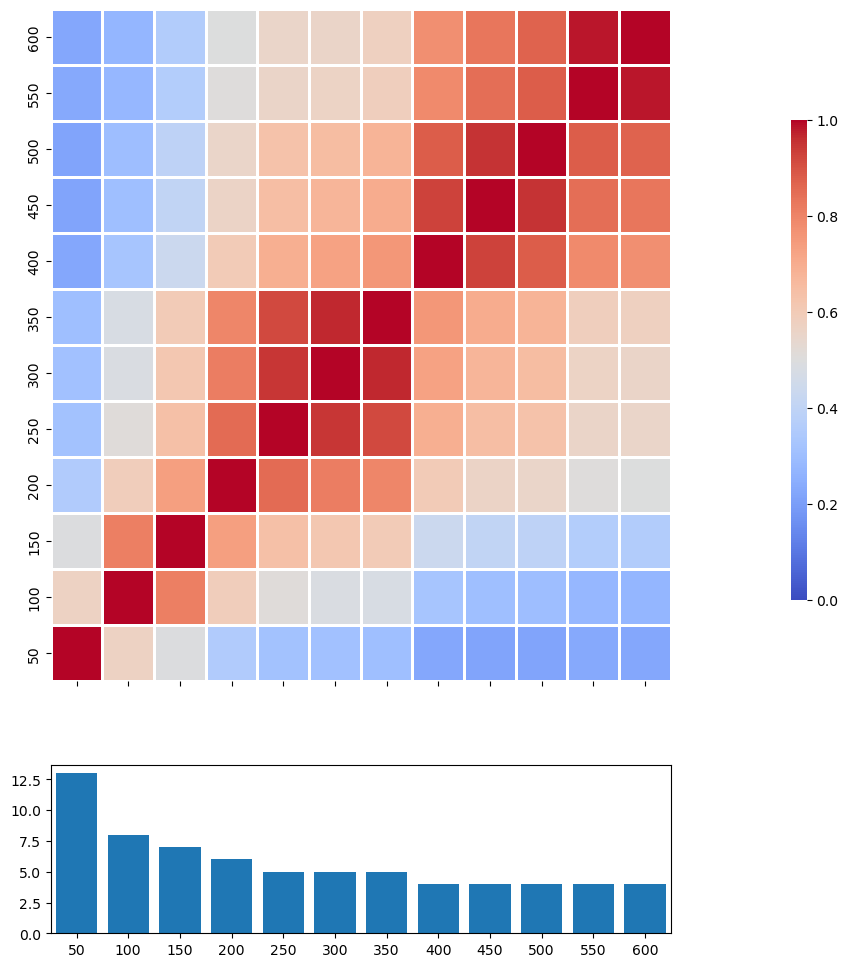

In [34]:
np.fill_diagonal(arand.values, 0.5)
arand_test = arand.fillna(0) + arand.T.fillna(0)


fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 12), sharex='col',
                            gridspec_kw={'height_ratios': [16,4]}
                            )
cbar_ax = fig.add_axes([1.05, .388, .02, .4])
sns.heatmap(arand_test,
                cmap=('coolwarm'),
                vmin=0,
                vmax=1,
                linewidths=1,
                ax=axs[0],
            cbar_ax=cbar_ax,
                #title= f"rand_index"
               ).invert_yaxis()

x_ticks = list(k_len.keys())
x_tick_pos = [i + 0.5 for i in range(len(x_ticks))]
axs[1].bar(x_tick_pos, k_len.values(), align='center')
plt.show()

In [36]:
seq_list = seq_list.rename(columns={"label_500":"global_trajectory"})
seq_adj = pd.DataFrame([seq_list.PATNR, seq_list.iloc[:,-4]]).T

In [38]:
#seq_list["label_230"] = trajectory.get_labels(sim_array, k=230)
data_heatmap = data_heatmap.drop("global_trajectory",axis=1) 
sep = data_heatmap.merge(seq_adj[["PATNR", "global_trajectory"]], on="PATNR", )

data_heatmap["global_trajectory_o"] = sep["global_trajectory"]
data_heatmap["global_trajectory"] = data_heatmap["global_trajectory_o"].replace(dict(zip(range(1,25),"ABCDEFGHIJKLMNOPQRSTUVWXYZ")))


In [39]:
data_heatmap.das28
data_heatmap["remision"] = data_heatmap.das28 < 2.6
data_heatmap.groupby("PATNR")[["global_trajectory","remision"]].max().groupby("global_trajectory").remision.mean()

global_trajectory
A    0.254079
B    0.904762
C    0.724409
D    0.446701
Name: remision, dtype: float64

In [40]:
seq_list["communi"] = communities
data_heatmap = data_heatmap.merge(seq_list[["PATNR", "communi"]], on="PATNR", )

In [41]:
pd.crosstab(data_heatmap["label"], data_heatmap["global_trajectory"])   

global_trajectory,A,B,C,D
label,,,,
1,118,815,110,57
2,559,58,47,10
3,75,59,522,25
4,86,389,127,303
5,300,55,66,54
6,395,20,71,45
7,126,103,99,265
8,12,26,9,11


In [43]:
data_heatmap.groupby("PATNR").tail(1).groupby("global_trajectory")[['aCCP positive', 'RF positive']].describe()
data_heatmap.groupby("PATNR").tail(1).groupby("global_trajectory").sex.count()
data_heatmap.groupby("PATNR").tail(1).groupby("global_trajectory").sex.mean()

global_trajectory
A    0.720280
B    0.599440
C    0.610236
D    0.604061
Name: sex, dtype: float64

In [44]:
#data_heatmap.sort_values("DATUM").groupby("PATNR").count().groupby("global_trajectory").days.describe()
data_heatmap.groupby(["global_trajectory","PATNR"]).count().TJC_28.reset_index("global_trajectory").groupby("global_trajectory").describe()

TJC_28                                              
                   count      mean       std  min  25%  50%  75%   max
global_trajectory                                                     
A                  429.0  3.895105  2.142298  2.0  2.0  3.0  5.0  15.0
B                  357.0  4.271709  2.049009  2.0  3.0  4.0  5.0  18.0
C                  254.0  4.137795  2.289499  2.0  3.0  4.0  5.0  20.0
D                  197.0  3.908629  2.367246  2.0  2.0  3.0  5.0  20.0

In [47]:
import umap
def draw_umap(data, n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine', title='', target= "label"):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    tsne_ng = pd.DataFrame(u, columns=["one","two"])
    tsne_ng["labels"] = target
    if n_components == 1:
        ax.scatter(u[:,0], range(len(u)), c=tsne_ng.labels)
    if n_components == 2:
        tsne_ng.plot.scatter("one","two", c = 'labels', cmap="tab10")
    plt.title(title, fontsize=18)
    return tsne_ng
#draw_umap(data=data_heatmap[features], n_neighbors=200, title='n_neighbors = {}'.format(200), metric="cosine", target=data_heatmap["global_trajectory_o"])

In [52]:
data_cluster_plot.groupby("global_trajectory").TJC_28_o.describe()

,count,mean,std,min,25%,50%,75%,max
global_trajectory,,,,,,,,
A,1671.0,3.709755,4.149182,0.0,1.0,2.0,5.0,26.0
B,1525.0,2.862951,3.687992,0.0,0.0,2.0,4.0,26.0
C,1051.0,3.338725,4.138715,0.0,1.0,2.0,5.0,28.0
D,770.0,7.264935,5.876708,0.0,3.0,6.0,10.0,28.0


In [54]:
data_cluster_plot[list(dmard_types.keys())] = data_cluster_plot[list(dmard_types.keys())] * 1
dmard_types

{'TNF_b_dmards': ['ETANERCEPT',
  'GOLIMUMAB',
  'INFLIXIMAB',
  'CERTOLIZUMAB_PEGOL',
  'ADALIMUMAB'],
 'IL6_b_dmards': ['CERTOLIZUMAB_PEGOL', 'TOCILIZUMAB'],
 'IL1_b_dmards': ['ANAKINRA'],
 'tcell_b_dmards': ['ABATACEPT'],
 'cs_dmards': ['METHOTREXATE',
  'HYDROXYCHLOROQUINE',
  'LEFLUNOMIDE',
  'SULFASALAZINE'],
 'jak_dmard': ['TOFACITINIB', 'BARICITINIB'],
 'XO_damrd': ['AZATHIOPRINE'],
 'OP_dmard': ['CYCLOPHOSPHAMIDE'],
 'TC_dmard': ['CICLOSPORINE'],
 'gld_dmard': ['SODIUM_AUROTHIOMALATE']}

In [55]:
traject_mapper = dict(zip(range(1,27),"ABCDEFGHIJKLMNOPQRSTUVWXYZ"))
traject_unmapper = dict(zip(traject_mapper.values(),traject_mapper.keys()))


In [56]:
from matplotlib.lines import Line2D

colormap = {1:"red",2:"grey",3:"blue",4:"purple",5:"green",6:"orange",7:"yellow",8:"teal",9:"pink",10:"lightgreen"}
def plot_clusters(dataset_clusters,
                  var, 
                  querys, 
                  range_ = None, 
                  target="label", 
                  axes = None, 
                  verbose= False, 
                  time_var = "days", 
                  reg_plot=True, 
                  *args, 
                  **kwargs):
    alpha = kwargs.get("alpha", 0.04)
    cmap = mpl.colormaps['tab20']
    traject_unmapper = dict(zip(traject_mapper.values(),traject_mapper.keys()))
    if kwargs.get("cmap",False):
        cmap = kwargs["cmap"]
    if kwargs.get("mapper",False):
        traject_unmapper = kwargs["mapper"]
    
    if range_ is None:
        range_ = sorted(dataset_clusters[target].unique())
    if axes:
        ax=axes
        fig = None
    else:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    handles, labels = ax.get_legend_handles_labels()
    patient_count = {}
    for i in range_:        
        dataset = dataset_clusters.query(querys).sort_values(['PATNR',time_var])
        patient_count[i] = len(dataset.PATNR.unique())
        if verbose:
            print(i, len(dataset.PATNR.unique()), len(dataset.PATNR.unique())/len(dataset_clusters.PATNR.unique()))
        for ids,data in dataset.groupby("PATNR"):
            data.plot(
            x=time_var,
            y=var,
            color=cmap(traject_unmapper.get(i, i)),
            alpha=alpha,
            ax=ax,
            label = i,
            legend=False,)
        if reg_plot:
            plt_it=sns.regplot(
                ax=ax,
                data = dataset,
                x=time_var,
                y=var,
                ci=80,
                label = f"{i} (n={len(dataset.PATNR.unique())})",
                color=cmap(traject_unmapper.get(i, i)),
                lowess=True,
                scatter=False,)
    def make_proxy(zvalue, cmapping, **kwargs):
        color = cmapping(traject_unmapper.get(zvalue, zvalue))
        return Line2D([0, 1], [0, 1], color=color, alpha=1, **kwargs)
    proxies = [make_proxy(item, cmap, linewidth=5, label="test") for item in range_]
    legend_label = [ f"{item} (n={patient_count[item]})" for item in range_]
    print(legend_label)
    ax.legend(proxies, legend_label)
    #print(proxies)
    return fig, ax, handles
#dataset_clusters.query(querys)

11.0 4.715474179249273
70.0 3.0927881898758587
126.0 3.2010789450439625
219.0 3.7607422769569014


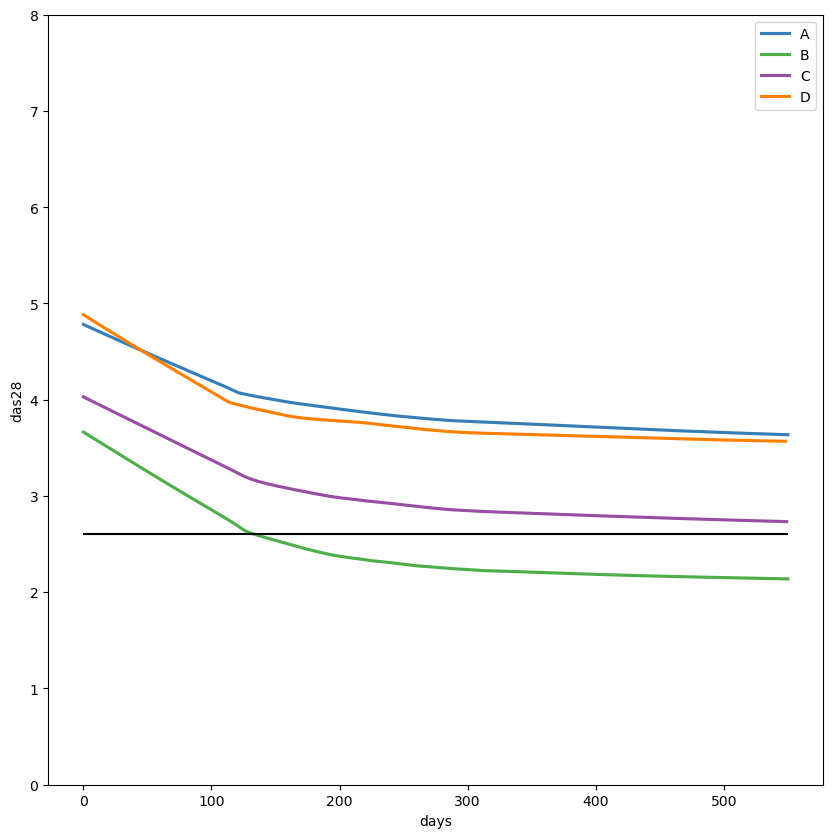

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
for i in sorted(data_cluster_plot.global_trajectory.unique()):
    sns.regplot(
                ax=ax,
                data = data_cluster_plot.query("global_trajectory == @i ",),
                x="days",
                y="das28",
                ci=90,
                lowess=True,
                scatter=False, 
                color=cmap(traject_unmapper.get(i, i)),
                label=i,
                marker=f"${i}$"
    )
    print(
    ax.lines[-1].get_data()[0][500],
    ax.lines[-1].get_data()[1][500]
    )
plt.legend()
ax.set_ylim((0,8))
plt.hlines(2.6, xmin=0,xmax=data_cluster_plot.days.max(), color="black", label="remision")



In [60]:
general_dataset = Propensity(         data_heatmap,                    
                    time_column= "days",
                    label_column = "label",
                    patient_indetifier= "PATNR",
                    med_array=dmards,)
general_dataset.calc_transition_matrix()
pd_from_total = general_dataset.traject_props



/exports/reum/nsteinz/Project_trajectories/trajectories/src/2_clustering/../utils/propensity.py:33: FutureWarning: The 'axis' keyword in SeriesGroupBy.shift is deprecated and will be removed in a future version. Call without passing 'axis' instead.
  .shift(-1, axis=0, fill_value=-1)


In [61]:
import random
scaler =MinMaxScaler(feature_range=(0, 1))
def edge_in_digraph(dataset, cutoff =0.15):
    #print(dataset)
    G = nx.DiGraph()
    labels_set = [0 for i in range(len(dataset)**2)]
    #print(labels_set)
    for nr,i in enumerate(dataset.round(2).T.iterrows()):
        labels_set[nr] = f"{i[0]}"
        for j in i[1].items():
            if i[0]==j[0]: #selfloops
                continue
            
            if j[1] <= 0:
                if -j[1] <= cutoff:
                    continue
            else:
                if j[1] <= cutoff:
                    continue
            #print(j[1])
            G.add_edge((i[0]),(j[0]),weight= j[1])
    return G

scale = data_heatmap.groupby("label").days.median().loc[volgorde]
scale = (scale-scale.min())/(scale.max()-scale.min())
B= edge_in_digraph(general_dataset.traject_props, 0.1)
scale

8    0.000000
7    0.030888
6    0.115830
5    0.204633
4    0.486486
3    0.563707
2    0.789575
1    1.000000
Name: days, dtype: float64

In [62]:
counts = general_dataset.count_dict
#print(traject_prob)
print([ counts.loc[v,u] for u,v in B.edges()])
B.edges(data=True)
counts.sum(axis=0)

[7, 15, 7, 17, 52, 52, 86, 59, 78, 219, 58, 60, 87, 111, 120, 68, 73, 65, 57, 105, 70]


8     58
7    534
6    448
5    403
4    686
3    506
2    489
1    656
dtype: int64

[ 15  17 219 111 120  68  73  65 105  70  87  52  52  86  59]
[0.25862069 0.29310345 0.31924198 0.16920732 0.2247191  0.12734082
 0.13670412 0.1284585  0.20750988 0.15625    0.17791411 0.12903226
 0.12903226 0.2133995  0.14640199]


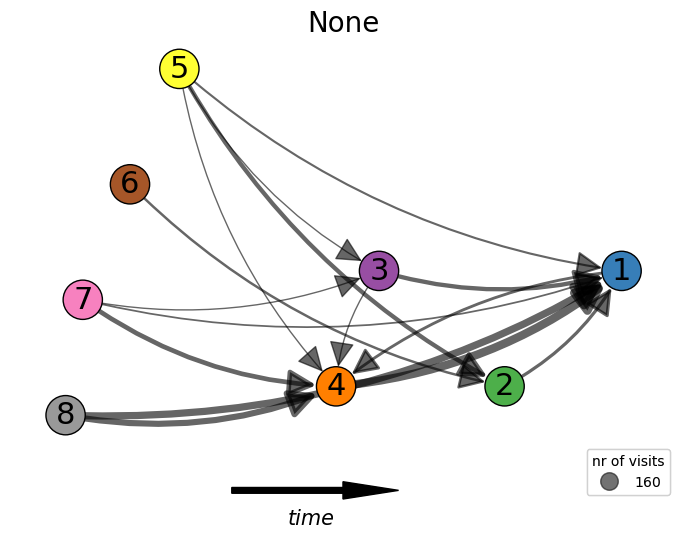

In [63]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.legend_handler import HandlerPatch,HandlerLine2D
import matplotlib.patches as mpatches

class HandlerRect(HandlerLine2D):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height,
                       fontsize, trans):
        x = (width//2)-5
        y = 0
        w = 15
        h = np.log2(0.5+orig_handle.get_markersize())**1.5
        print((orig_handle.get_markersize()))
        #print(height)
        # create
        p = patches.Rectangle(xy=(x, y), width=w, height=h, color="grey", alpha=0.6)
        # update with data from oryginal object
        self.update_prop(p, p, legend)
        # move xy to legend
        p.set_transform(trans)
        return [p]



from sklearn.cluster import KMeans
def define_scaling(scaling):
    kmeans  = KMeans(3).fit(scaling.values.reshape(-1, 1))
    #print(kmeans.labels_)
    volgorede_dict = dict(zip(scaling.index,kmeans.labels_))
    #print(volgorede_dict)
    lijst, lijst_fixed = {}, {}
    for i in volgorede_dict:
        lijst[volgorede_dict[i]] = lijst.get(volgorede_dict[i], []) + [i]
    for nr,i in enumerate(lijst):
        lijst_fixed[nr] = lijst[i]
    return lijst_fixed
#define_scaling(scaling)       



traject_prob = general_dataset.traject_props
#traject_prob = (traject_prob/traject_prob.sum(axis=0)).round(2)
def plot_traject(general_dataset, scale,title="None", cutoff=0.1, size=None):
    probs = general_dataset.traject_props
    counts = general_dataset.count_dict
    if type(size) == type(None):
        size =800/5
    cmap = mpl.colormaps['Set1']
    fig, ax = plt.subplots(nrows=1, ncols=1)
    min_prob = cutoff
    B= edge_in_digraph(probs,min_prob)
    if B.number_of_nodes() == 0:
        return
    used_counts = np.array([counts.loc[v,u] for u,v in B.edges()])
    used_probs = np.array([probs.loc[v,u] for u,v in B.edges()])
    print(used_counts)
    print(used_probs)
    scaling = define_scaling(scale)
    left_nodes = [x for x in scaling[0]]
    middle_nodes = [x for x in scaling[1]]
    right_nodes = [x for x in scaling[2]]
    #end_nodes = [1,5]
    scale_nr = [i[x] for i in scaling.values() for x in range(len(i))]
    
    
    pos = {n: (scale.loc[(n)], i +(1/len(left_nodes))) for i, n in enumerate(left_nodes)}
    pos.update({n: (scale.loc[(n)], i +(1/len(middle_nodes))) for i, n in enumerate(middle_nodes)})
    pos.update({n: (scale.loc[(n)], i +(1/len(right_nodes))) for i, n in enumerate(right_nodes)})
    options_edge = {
        "arrowsize":40,
        "node_size":800,
        "connectionstyle":"arc3, rad=0.15"
    }
    #print(np.array([W["weight"] for u,v,W in B.edges(data=True)]).reshape(-1,1))
    nodes = nx.draw_networkx_nodes(B, pos, nodelist=scale.index, node_color=cmap(scale.index), edgecolors="black", node_size=size*5)
    m_weights = (scaler.fit_transform(np.array([W["weight"] for u,v,W in B.edges(data=True)]).reshape(-1,1))+0.2)*5

    width = nx.draw_networkx_edges(B, pos, alpha=0.6, width=m_weights,  **options_edge)
    nx.draw_networkx_labels(B, pos, font_size=22)
    y = pd.DataFrame(pos).mean(axis=1)[0]
    x = pd.DataFrame(pos).mean(axis=1)[0] -0.1
    plt.arrow(x=x, dx=0.2, y=y-0.8, dy=0, width=0.05, color="black",head_length=0.1)
    plt.text(x+0.1, y-1.1, 'time', style ='italic',
            fontsize = 15, color ="Black")
    plt.tight_layout()
    plt.axis("off")
    
    ax.set_title(title, fontdict={"fontsize":20})
    fig = mpl.pyplot.gcf()
    fig.set_figheight(5)
    fig.set_figwidth(7)
    sc = plt.scatter(size, size, s=size, alpha=0)
    legend_1 = plt.legend(*sc.legend_elements("sizes", num=3, alpha=0.5), title="nr of visits", loc="lower right")
    lines= plt.scatter(m_weights, m_weights, s=used_counts, alpha=0)
    #legend_2 = plt.legend(*lines.legend_elements("sizes", num=4, alpha=0.5), handler_map={Line2D : HandlerRect()}, title="nr of transitions", loc="best")
    fig.add_artist(legend_1)
    plt.xlim((-0.1,1.1))
    plt.ylim((-0.5,3.5))
    plt.savefig(f'{results_dir}/{title}.png', dpi=900, transparent=True, bbox_inches='tight')
    plt.show()
    return used_probs

width = plot_traject(general_dataset, scale = scale, cutoff=0.12)


In [67]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.legend_handler import HandlerPatch,HandlerLine2D

In [66]:
node_size = data_heatmap.groupby("label").count().TJC_28.values

In [69]:
def moving_matrix(df, query="ilevel_0 in ilevel_0"):
    dict_from = {x:{x:0 for x in volgorde} for x in volgorde}
    data_loop = df.query(query)[["start_label","eind_label"]].reset_index()
    #print(data_loop)
    for point in data_loop.transpose():
        row = data_loop.iloc[point]
        try:
            dict_from[row.start_label][row.eind_label] += 1
        except KeyError: 
            continue
    from_mi = pd.MultiIndex.from_product([["From"],dict_from.keys()])
    to_mi = pd.MultiIndex.from_product([["To"],dict_from.keys()])
    transition_matrix = pd.DataFrame.from_dict(dict_from)
    transition_matrix.columns = from_mi
    transition_matrix.index = to_mi
    return transition_matrix

x = moving_matrix(data_cluster_plot.sort_values("days").groupby("PATNR").tail(1))

In [70]:
def moving_days_matrix(df, query="ilevel_0 in ilevel_0"):
    dict_from = {x:{x:0 for x in volgorde} for x in volgorde}
    data_loop = df.query(query)[["start_label","eind_label","days"]].reset_index()
    #print(data_loop)
    for point in data_loop.transpose():
        row = data_loop.iloc[point]
        try:
            dict_from[row.start_label][row.eind_label] += row.days
        except KeyError: 
            continue
    from_mi = pd.MultiIndex.from_product([["From"],dict_from.keys()])
    to_mi = pd.MultiIndex.from_product([["To"],dict_from.keys()])
    transition_matrix = pd.DataFrame.from_dict(dict_from)
    transition_matrix.columns = from_mi
    transition_matrix.index = to_mi
    return transition_matrix

days = moving_days_matrix(data_cluster_plot.sort_values("days").groupby("PATNR").tail(1))

In [71]:
data_cluster_plot["remision"] = data_cluster_plot.query("days > 90").das28 < 2.6

In [72]:
data_cluster_plot.groupby("PATNR").tail(1).remision.sum()/len(data_cluster_plot.PATNR.unique())

0.4219886822958771

In [73]:
len(data_cluster_plot.query("start_label != 1 & eind_label == 1").PATNR.unique())
#start_label
#eind_label
data_cluster_plot["label"] = data_heatmap.label

In [85]:
traject_label_ = data_heatmap.groupby("PATNR").head(1)[["PATNR", "global_trajectory"]]

In [ ]:

#data_heatmap.to_csv(data_dir+"labeled_data.csv", index=False)


In [87]:
from scipy import stats

def print_describe(dataset, name="fill in",index=True):
    print(f"{'features'*index} & {name} ")
    for i in features +[ "dmard_usage", "sex"]:
        if i in features:
            i = i+"_o"
        #print(dataset[i].dtypes)
        if dataset[i].dtypes == "object":
            continue
        elif dataset[i].dtypes == "bool":
            print(f"{i*index} {'(%)'*index} & {round(dataset[i].sum(),2)} ({round(dataset[i].mean(), 2)}) ")
        else:
            conf = stats.norm.interval(0.95, loc=dataset[i].mean(), scale=dataset[i].std(ddof=1))
            print(f"{i*index} {'(IQR)'*index} & {round(dataset[i].mean(),2)}  ({round(dataset[i].quantile(q=0.25),2)} - {round(dataset[i].quantile(q=0.75),2)}) ")

print_describe(data_heatmap, index=True)

features & fill in 
TJC_28_o (IQR) & 3.92  (1.0 - 5.0) 
SJC_28_o (IQR) & 2.95  (0.0 - 4.0) 
ESR_o (IQR) & 25.96  (9.0 - 36.0) 
leukocytes_o (IQR) & 8.16  (6.25 - 9.6) 
hb_corrected_o (IQR) & 8.31  (7.9 - 8.9) 
MCV_o (IQR) & 90.97  (88.0 - 95.0) 
thrombocytes_o (IQR) & 293.37  (237.0 - 335.0) 
dmard_usage (%) & 4003 (0.8) 
sex (IQR) & 0.66  (0.0 - 1.0) 


In [88]:
data_heatmap.columns

Index(['TJC_28', 'SJC_28', 'ESR', 'leukocytes', 'hb_corrected', 'MCV',
       'thrombocytes', 'TJC_28_o', 'SJC_28_o', 'ESR_o', 'leukocytes_o',
       'hb_corrected_o', 'MCV_o', 'thrombocytes_o', 'das28_n', 'das28',
       'das44', 'SJC_44_o', 'TJC_44_o', 'aCCP positive', 'RF positive',
       'label', 'days', 'days_nlp', 'PATNR', 'DATUM', 'Age', 'sex',
       'dmard_usage', 'symptomDuration', 'Hemoglobine', 'sequence', 'Age_n',
       'remision', 'ABATACEPT', 'ADALIMUMAB', 'ANAKINRA',
       'SODIUM_AUROTHIOMALATE', 'AZATHIOPRINE', 'BARICITINIB',
       'CERTOLIZUMAB_PEGOL', 'CICLOSPORINE', 'CYCLOPHOSPHAMIDE', 'ETANERCEPT',
       'GOLIMUMAB', 'HYDROXYCHLOROQUINE', 'INFLIXIMAB', 'LEFLUNOMIDE',
       'METHOTREXATE', 'SULFASALAZINE', 'TOCILIZUMAB', 'TOFACITINIB',
       'METHYLPREDNISOLONE', 'PREDNISOLONE', 'TNF_b_dmards', 'IL6_b_dmards',
       'IL1_b_dmards', 'tcell_b_dmards', 'cs_dmards', 'jak_dmard', 'XO_damrd',
       'OP_dmard', 'TC_dmard', 'gld_dmard', 'count', 'no_med', 'med',
 

In [89]:

def print_latex_table_EHR(dataset, query = "label==@j" , type_ = "trajectory", volgorde= volgorde):
    if query == None:
        query = 'ilevel_0 in ilevel_0'
    print("Features", end ="")
    for i in volgorde:
        print(" & ", end="")
        print(type_,i, end="")
    print("\\\\\\hline")
    print("n=", end= "")
    for j in volgorde:
        print(" & ", end="")
        z = (dataset.query(query)
                        .groupby("PATNR")
                        .head(1))
        print(f"{z.count().iloc[0]}", end="")
    print("\\\\")
    for i in features :
        print(i,"$\space$ (IQR) $\space\dagger$ ", end= "")
        for j in volgorde:
            print(" & ", end="")
            z = (dataset.query(query)
                        .groupby("PATNR")
                        .head(1)[i+"_o"])
            print(f"{round(z.median(),1)} ({round(z.quantile(q=0.25),1)} - {round(z.quantile(q=0.75),1)})", end="")
        print("\\\\")
    for i in ["Hemoglobine","das28","Age","days"]:
        print(i,"$\space$ (IQR)", end= "")
        for j in volgorde:
            print(" & ", end="")
            z = (dataset.query(query)
                        .groupby("PATNR")
                        .head(1)[i])
            print(f"{round(z.median(),1)} ({round(z.quantile(q=0.25),1)} - {round(z.quantile(q=0.75),1)})", end="")

        print("\\\\")
    for i in ["dmard_usage","RF positive", "aCCP positive", "sex"]:
        print(i,"(\\%)", end= "")
        for j in volgorde:
            print(" & ", end="")
            z = (dataset.query(query)
                        .groupby("PATNR")
                        .head(1)[i])
            print(f"{int(round(z.sum(),0))} ({round(z.mean()*100, 1)})", end="")

        print("\\\\")

data = data_heatmap
#data = data[data.trajectory_label.isin(volgorde[:4])]
#data["label"] = data.trajectory_label
print_latex_table_EHR(data, volgorde =volgorde[:4])

Features & trajectory 8 & trajectory 7 & trajectory 6 & trajectory 5\\\hline
n= & 55 & 391 & 266 & 330\\
TJC_28 $\space$ (IQR) $\space\dagger$  & 2.0 (1.0 - 4.0) & 12.0 (9.0 - 15.0) & 4.0 (2.0 - 7.0) & 5.0 (3.0 - 6.0)\\
SJC_28 $\space$ (IQR) $\space\dagger$  & 2.0 (1.0 - 3.0) & 10.0 (8.0 - 13.0) & 4.0 (2.0 - 7.0) & 4.0 (3.0 - 5.0)\\
ESR $\space$ (IQR) $\space\dagger$  & 17.0 (9.0 - 31.0) & 31.0 (14.0 - 46.0) & 74.0 (62.0 - 96.0) & 34.0 (29.0 - 41.0)\\
leukocytes $\space$ (IQR) $\space\dagger$  & 3.7 (3.2 - 4.4) & 8.3 (6.7 - 10.2) & 8.8 (7.1 - 10.8) & 8.4 (7.0 - 9.9)\\
hb_corrected $\space$ (IQR) $\space\dagger$  & 4.5 (4.2 - 4.7) & 8.2 (7.5 - 8.8) & 7.5 (6.8 - 8.1) & 8.3 (7.9 - 8.7)\\
MCV $\space$ (IQR) $\space\dagger$  & 91.0 (89.0 - 93.0) & 89.0 (86.0 - 92.0) & 89.0 (85.0 - 92.0) & 90.0 (87.0 - 93.0)\\
thrombocytes $\space$ (IQR) $\space\dagger$  & 267.0 (240.0 - 291.5) & 301.0 (251.0 - 370.5) & 375.5 (297.2 - 455.8) & 312.0 (272.2 - 358.8)\\
Hemoglobine $\space$ (IQR) & 4.2 (4.0 - 4

In [90]:
data = data_heatmap.sort_values("days").groupby("PATNR").tail(1)
#data["label"] = data.label
data = data.loc[data.label.isin(volgorde[:4])].copy()
print_latex_table_EHR(data, type_="cluster", volgorde =volgorde[:4])

Features & cluster 8 & cluster 7 & cluster 6 & cluster 5\\\hline
n= & 0 & 59 & 83 & 72\\
TJC_28 $\space$ (IQR) $\space\dagger$  & nan (nan - nan) & 11.0 (8.0 - 14.0) & 3.0 (0.0 - 4.5) & 4.5 (3.0 - 6.0)\\
SJC_28 $\space$ (IQR) $\space\dagger$  & nan (nan - nan) & 10.0 (8.0 - 12.5) & 2.0 (0.0 - 4.5) & 4.0 (3.0 - 5.0)\\
ESR $\space$ (IQR) $\space\dagger$  & nan (nan - nan) & 28.0 (12.5 - 40.0) & 72.0 (61.0 - 92.0) & 33.0 (29.0 - 38.2)\\
leukocytes $\space$ (IQR) $\space\dagger$  & nan (nan - nan) & 8.6 (7.0 - 10.7) & 9.7 (7.2 - 11.5) & 8.0 (6.9 - 9.4)\\
hb_corrected $\space$ (IQR) $\space\dagger$  & nan (nan - nan) & 8.2 (7.5 - 8.7) & 7.5 (6.9 - 8.0) & 8.0 (7.5 - 8.7)\\
MCV $\space$ (IQR) $\space\dagger$  & nan (nan - nan) & 89.0 (85.5 - 93.0) & 91.0 (86.5 - 94.2) & 92.0 (88.0 - 94.2)\\
thrombocytes $\space$ (IQR) $\space\dagger$  & nan (nan - nan) & 320.0 (248.0 - 366.5) & 350.0 (296.5 - 433.0) & 303.0 (259.0 - 355.8)\\
Hemoglobine $\space$ (IQR) & nan (nan - nan) & 7.8 (7.3 - 8.7) & 7.4

In [91]:
data = data_heatmap.sort_values("days").groupby("PATNR").tail(1)
#data["label"] = data.label
data = data.loc[data.label.isin(volgorde[4:])].copy()
print_latex_table_EHR(data, type_="cluster", volgorde =volgorde[4:])

Features & cluster 4 & cluster 3 & cluster 2 & cluster 1\\\hline
n= & 219 & 175 & 185 & 444\\
TJC_28 $\space$ (IQR) $\space\dagger$  & 4.0 (3.0 - 6.0) & 1.0 (0.0 - 2.0) & 1.0 (0.0 - 2.0) & 0.0 (0.0 - 1.0)\\
SJC_28 $\space$ (IQR) $\space\dagger$  & 3.0 (1.0 - 4.0) & 0.0 (0.0 - 1.0) & 0.0 (0.0 - 1.0) & 0.0 (0.0 - 0.0)\\
ESR $\space$ (IQR) $\space\dagger$  & 9.0 (6.0 - 14.0) & 11.0 (6.0 - 17.0) & 33.0 (28.0 - 39.0) & 6.0 (2.0 - 11.0)\\
leukocytes $\space$ (IQR) $\space\dagger$  & 7.0 (6.1 - 8.0) & 10.0 (8.9 - 11.2) & 7.3 (6.2 - 8.3) & 6.2 (5.2 - 7.1)\\
hb_corrected $\space$ (IQR) $\space\dagger$  & 8.7 (8.2 - 9.1) & 8.6 (8.2 - 9.2) & 8.2 (7.9 - 8.7) & 8.7 (8.3 - 9.2)\\
MCV $\space$ (IQR) $\space\dagger$  & 92.0 (89.0 - 95.5) & 92.0 (89.0 - 95.0) & 93.0 (90.0 - 96.0) & 93.2 (90.0 - 97.0)\\
thrombocytes $\space$ (IQR) $\space\dagger$  & 253.0 (220.5 - 289.5) & 293.0 (248.5 - 334.0) & 274.0 (233.0 - 319.0) & 243.0 (209.0 - 278.0)\\
Hemoglobine $\space$ (IQR) & 8.5 (8.0 - 9.0) & 8.5 (7.9 - 9.

In [93]:
data = data_heatmap.sort_values("days").groupby("PATNR").head(1).reset_index()
print_latex_table_EHR(data, query=None,type_="", volgorde =[5])

Features &  5\\\hline
n= & 1237\\
TJC_28 $\space$ (IQR) $\space\dagger$  & 4.0 (2.0 - 8.0)\\
SJC_28 $\space$ (IQR) $\space\dagger$  & 3.0 (1.0 - 7.0)\\
ESR $\space$ (IQR) $\space\dagger$  & 28.0 (11.0 - 45.0)\\
leukocytes $\space$ (IQR) $\space\dagger$  & 7.9 (6.3 - 9.6)\\
hb_corrected $\space$ (IQR) $\space\dagger$  & 8.4 (7.8 - 8.9)\\
MCV $\space$ (IQR) $\space\dagger$  & 90.0 (87.0 - 93.0)\\
thrombocytes $\space$ (IQR) $\space\dagger$  & 290.0 (246.0 - 352.0)\\
Hemoglobine $\space$ (IQR) & 8.2 (7.5 - 8.8)\\
das28 $\space$ (IQR) & 4.3 (3.3 - 5.3)\\
Age $\space$ (IQR) & 61.0 (51.0 - 71.0)\\
days $\space$ (IQR) & 0.0 (0.0 - 0.0)\\
dmard_usage (\%) & 970 (78.4)\\
RF positive (\%) & 570 (46.1)\\
aCCP positive (\%) & 571 (46.2)\\
sex (\%) & 797 (64.4)\\


In [94]:
ids = data.PATNR.copy()

In [95]:
data = data_heatmap.sort_values("days").groupby("PATNR").tail(1).reset_index()
data = data[data.PATNR.isin(ids)]
print_latex_table_EHR(data, query=None,type_="", volgorde =[5])

Features &  5\\\hline
n= & 1237\\
TJC_28 $\space$ (IQR) $\space\dagger$  & 1.0 (0.0 - 3.0)\\
SJC_28 $\space$ (IQR) $\space\dagger$  & 0.0 (0.0 - 2.0)\\
ESR $\space$ (IQR) $\space\dagger$  & 14.0 (6.0 - 29.0)\\
leukocytes $\space$ (IQR) $\space\dagger$  & 7.2 (6.0 - 8.8)\\
hb_corrected $\space$ (IQR) $\space\dagger$  & 8.5 (8.0 - 9.0)\\
MCV $\space$ (IQR) $\space\dagger$  & 92.0 (89.0 - 96.0)\\
thrombocytes $\space$ (IQR) $\space\dagger$  & 264.0 (225.0 - 314.0)\\
Hemoglobine $\space$ (IQR) & 8.3 (7.7 - 8.9)\\
das28 $\space$ (IQR) & 2.9 (2.1 - 3.9)\\
Age $\space$ (IQR) & 61.0 (51.0 - 71.0)\\
days $\space$ (IQR) & 375.0 (224.0 - 462.0)\\
dmard_usage (\%) & 983 (79.5)\\
RF positive (\%) & 570 (46.1)\\
aCCP positive (\%) & 571 (46.2)\\
sex (\%) & 797 (64.4)\\


8    0.000000
7    0.320311
6    0.447028
5    0.466961
4    0.650872
3    0.734053
2    0.817999
1    1.000000
Name: days, dtype: float64
label
8      58
5     475
6     531
7     593
2     674
3     681
4     905
1    1100
Name: TJC_28, dtype: int64


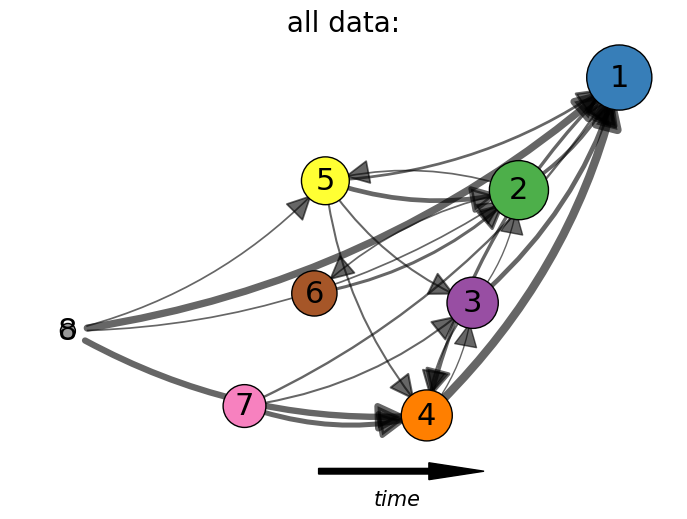

In [99]:
def edge_in_digraph(dataset, cutoff =0.15):
    G = nx.DiGraph()
    labels_set = [0 for i in range(len(dataset)**2)]
    #print(labels_set)
    for nr,i in enumerate(dataset.round(2).T.iterrows()):
        labels_set[nr] = f"{i[0]}"
        for j in i[1].items():
            if i[0]==j[0]:
                continue
            
            if j[1] <= 0:
                if -j[1] <= cutoff:
                    continue
            else:
                if j[1] <= cutoff:
                    continue
            #print(j[1])
            G.add_edge((i[0]),(j[0]),weight= j[1])
    return G

min_prob = 0.15
B= edge_in_digraph(traject_prob,min_prob)
#B.edges(data=True)

from sklearn.cluster import KMeans
def define_scaling(scaling):
    kmeans  = KMeans(3).fit(scaling.values.reshape(-1, 1))
    #print(kmeans.labels_)
    volgorede_dict = dict(zip(scaling.index,kmeans.labels_))
    #print(volgorede_dict)
    lijst, lijst_fixed = {}, {}
    for i in volgorede_dict:
        lijst[volgorede_dict[i]] = lijst.get(volgorede_dict[i], []) + [i]
    for nr,i in enumerate(lijst):
        lijst_fixed[nr] = lijst[i]
    return lijst_fixed

#define_scaling(scaling)       




def plot_traject(probs, scale,title="None", cutoff=1, size=None, order:dict= None):
    if type(size) == type(None):
        size =800
    cmap = mpl.colormaps['Set1']
    fig, ax = plt.subplots(nrows=1, ncols=1)
    min_prob = cutoff
    B= edge_in_digraph(probs,min_prob)
    scaling = define_scaling(scale)
    if order:
        left_nodes = order["left"]
        middle_nodes = order["middle"]
        right_nodes = order["right"]
    else:
        left_nodes = [x for x in scaling[0]]
        middle_nodes = [x for x in scaling[1]]
        right_nodes = [x for x in scaling[2]]
    #end_nodes = [1,5]
    scale_nr = [i[x] for i in scaling.values() for x in range(len(i))]
    
    
    pos = {n: (scale.loc[(n)], i +(1/len(left_nodes))) for i, n in enumerate(left_nodes)}
    pos.update({n: (scale.loc[(n)], i +(1/len(middle_nodes))) for i, n in enumerate(middle_nodes)})
    pos.update({n: (scale.loc[(n)], i +(1/len(right_nodes))) for i, n in enumerate(right_nodes)})
    options_edge = {
        "arrowsize":40,
        "node_size":800,
        "connectionstyle":"arc3, rad=0.15"
    }
    #print(np.array([W["weight"] for u,v,W in B.edges(data=True)]).reshape(-1,1))
    nx.draw_networkx_nodes(B, pos, nodelist=scale.index, node_color=cmap(scale.index), edgecolors="black", node_size=size)
    m_weights = (scaler.fit_transform(np.array([W["weight"] for u,v,W in B.edges(data=True)]).reshape(-1,1))+0.2)*5
    nx.draw_networkx_edges(B, pos, alpha=0.6, width=m_weights,  **options_edge)
    nx.draw_networkx_labels(B, pos, font_size=22)
    y = pd.DataFrame(pos).mean(axis=1)[0]
    x = pd.DataFrame(pos).mean(axis=1)[0] -0.1
    plt.arrow(x=x, dx=0.2, y=y-0.8, dy=0, width=0.05, color="black",head_length=0.1)
    plt.text(x+0.1, y-1.1, 'time', style ='italic',
            fontsize = 15, color ="Black")
    plt.tight_layout()
    plt.axis("off")
    
    ax.set_title(title, fontdict={"fontsize":20})
    fig = mpl.pyplot.gcf()
    fig.set_figheight(5)
    fig.set_figwidth(7)
    plt.savefig(f'{results_dir}/{title}.png', dpi=900, transparent=True, bbox_inches='tight')
    plt.show()

scaling = data_heatmap.groupby("label").days.mean().fillna(0).loc[volgorde]
scaling = (scaling-scaling.min())/(scaling.max()-scaling.min())
print(scaling)
size = data_heatmap.groupby("label").count().iloc[:,0].sort_values()
print(size)
plot_traject(general_dataset.traject_props, scaling,f" all data: ", size = size*2, cutoff=0.1)

A


/exports/reum/nsteinz/Project_trajectories/trajectories/src/2_clustering/../utils/propensity.py:33: FutureWarning: The 'axis' keyword in SeriesGroupBy.shift is deprecated and will be removed in a future version. Call without passing 'axis' instead.
  .shift(-1, axis=0, fill_value=-1)


     8     7      6     5     4     3      2     1
8  0.0   0.0    0.0   0.0   0.0   0.0    1.0   0.0
7  0.0  24.0   27.0  18.0   3.0   3.0   11.0   0.0
6  0.0  23.0  165.0  10.0   1.0   2.0   54.0   2.0
5  4.0  21.0   35.0  62.0   8.0   2.0   56.0   5.0
4  0.0   2.0    6.0  24.0  11.0   4.0   22.0   1.0
3  0.0   4.0    9.0  22.0   2.0  12.0   14.0   2.0
2  6.0  28.0   70.0  82.0  20.0  34.0  190.0  31.0
1  2.0   3.0    9.0  29.0   6.0   3.0   45.0  12.0


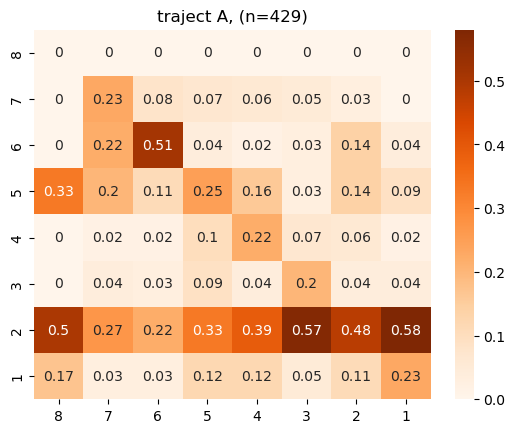

8    0.000000
7    0.442392
6    0.409575
5    0.415781
4    0.728912
3    0.598169
2    0.753960
1    1.000000
Name: days, dtype: float64
8     12.0
7    105.0
6    321.0
5    247.0
4     51.0
3     60.0
2    393.0
1     53.0
dtype: float64


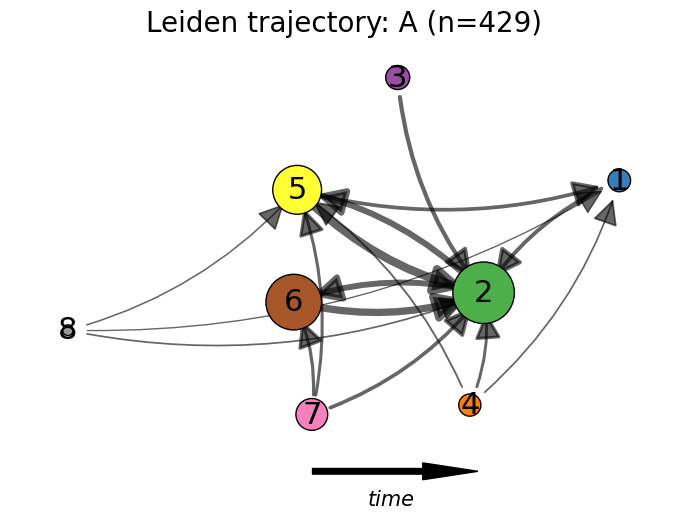

B


/exports/reum/nsteinz/Project_trajectories/trajectories/src/2_clustering/../utils/propensity.py:33: FutureWarning: The 'axis' keyword in SeriesGroupBy.shift is deprecated and will be removed in a future version. Call without passing 'axis' instead.
  .shift(-1, axis=0, fill_value=-1)


      8     7    6     5      4     3     2      1
8   1.0   1.0  0.0   0.0    0.0   0.0   0.0    1.0
7   0.0  19.0  3.0   4.0   10.0   1.0   1.0    6.0
6   0.0   2.0  6.0   0.0    1.0   0.0   1.0    1.0
5   2.0   5.0  0.0  10.0    7.0   2.0   2.0    5.0
4   7.0  29.0  1.0  13.0  107.0  12.0   9.0   92.0
3   1.0   3.0  0.0   1.0   14.0   0.0   3.0   23.0
2   0.0   4.0  0.0   3.0    7.0   1.0   4.0   17.0
1  15.0  38.0  9.0  23.0  195.0  34.0  32.0  380.0


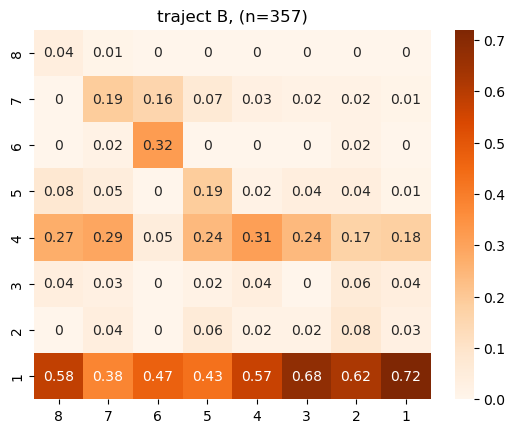

8    0.000000
7    0.143235
6    0.178861
5    0.341991
4    0.510444
3    0.671028
2    0.605212
1    1.000000
Name: days, dtype: float64
8     26.0
7    101.0
6     19.0
5     54.0
4    341.0
3     50.0
2     52.0
1    525.0
dtype: float64


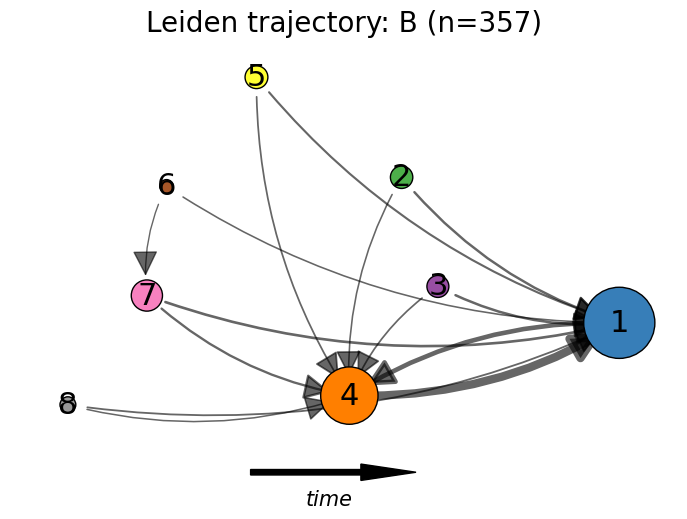

C


/exports/reum/nsteinz/Project_trajectories/trajectories/src/2_clustering/../utils/propensity.py:33: FutureWarning: The 'axis' keyword in SeriesGroupBy.shift is deprecated and will be removed in a future version. Call without passing 'axis' instead.
  .shift(-1, axis=0, fill_value=-1)


     8     7     6     5     4      3     2     1
8  0.0   1.0   0.0   0.0   0.0    0.0   0.0   0.0
7  0.0  22.0   5.0   5.0   3.0   19.0   0.0   0.0
6  0.0   5.0  23.0   2.0   1.0    6.0   2.0   0.0
5  1.0   5.0   3.0  13.0   2.0   16.0   1.0   1.0
4  3.0   5.0   2.0   6.0  32.0   44.0   0.0   7.0
3  4.0  49.0  33.0  27.0  54.0  210.0  21.0  32.0
2  1.0   0.0   0.0   1.0   5.0   22.0   3.0   1.0
1  0.0   2.0   1.0   5.0   5.0   61.0  10.0  15.0


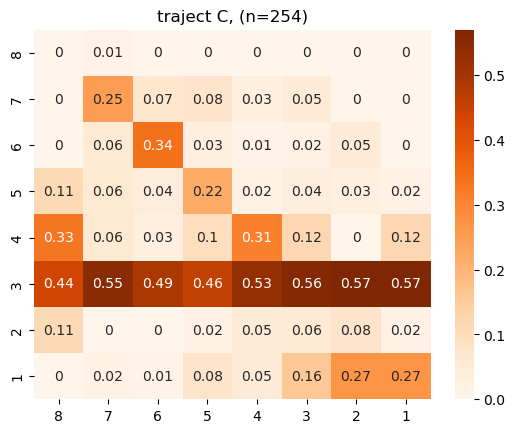

8    0.000000
7    0.284937
6    0.170652
5    0.378660
4    0.674990
3    0.719487
2    0.775265
1    1.000000
Name: days, dtype: float64
8      9.0
7     89.0
6     67.0
5     59.0
4    102.0
3    378.0
2     37.0
1     56.0
dtype: float64


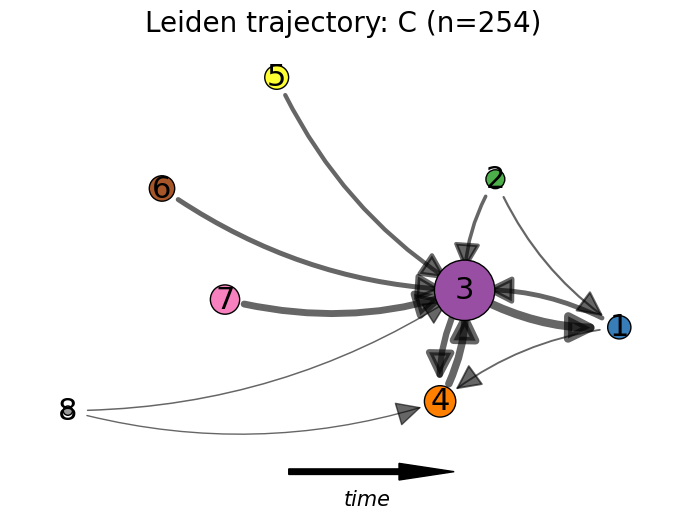

D


/exports/reum/nsteinz/Project_trajectories/trajectories/src/2_clustering/../utils/propensity.py:33: FutureWarning: The 'axis' keyword in SeriesGroupBy.shift is deprecated and will be removed in a future version. Call without passing 'axis' instead.
  .shift(-1, axis=0, fill_value=-1)


     8     7     6     5      4    3    2     1
8  2.0   0.0   0.0   0.0    0.0  0.0  0.0   0.0
7  3.0  88.0  10.0  14.0   24.0  2.0  2.0   3.0
6  0.0   5.0  26.0   2.0    2.0  0.0  1.0   0.0
5  0.0  17.0   2.0  14.0    8.0  4.0  1.0   2.0
4  5.0  84.0   2.0   9.0  134.0  5.0  3.0  11.0
3  1.0  12.0   1.0   2.0    8.0  0.0  0.0   1.0
2  0.0   3.0   0.0   0.0    3.0  0.0  0.0   2.0
1  0.0  30.0   0.0   2.0   13.0  7.0  0.0   3.0


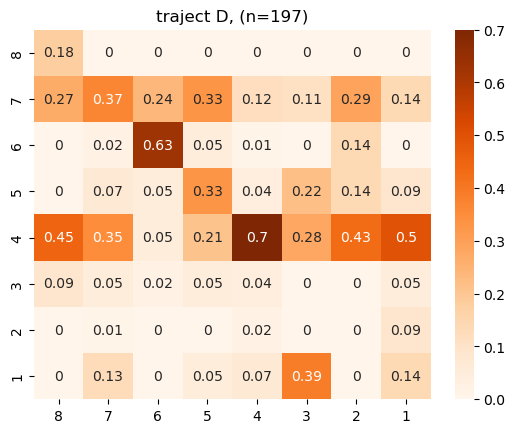

8    0.000000
7    0.294763
6    0.820698
5    0.651208
4    0.712815
3    0.732933
2    0.889124
1    1.000000
Name: days, dtype: float64
8     11.0
7    239.0
6     41.0
5     43.0
4    192.0
3     18.0
2      7.0
1     22.0
dtype: float64


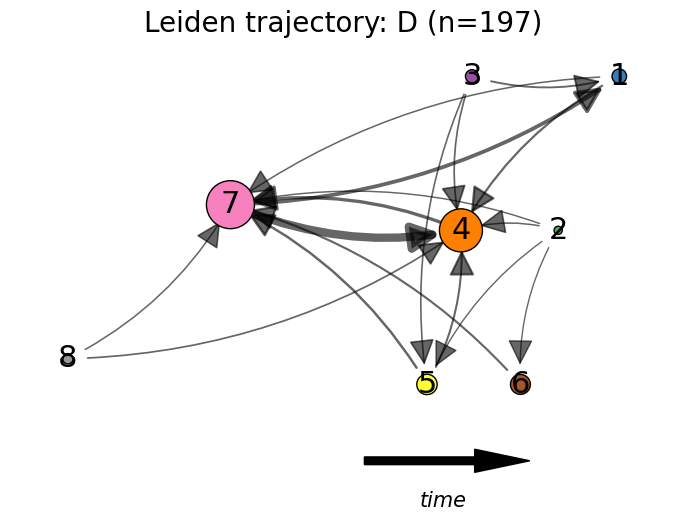

In [100]:
scaling_frame = pd.DataFrame(np.zeros(len(volgorde)), index = volgorde, columns=["days"] )
test_frame = pd.DataFrame(np.zeros((len(volgorde),len(volgorde))), columns=volgorde, index = volgorde )
for i in sorted(data_heatmap.global_trajectory.unique(), reverse=False):
    print(i)
    general_dataset = Propensity(data_heatmap.query(f"global_trajectory == '{i}'"),                    
                    time_column= "days",
                    label_column = "label",
                    patient_indetifier= "PATNR",
                    med_array=dmards,)
    general_dataset.calc_transition_matrix()
    #traject_counts = general_dataset.count_dict
    traject_counts = (general_dataset.count_dict + test_frame).fillna(0).loc[volgorde,volgorde]
    print(traject_counts)
    patients = len(data_heatmap.query(f"global_trajectory == '{i}'").PATNR.unique())
    traject_prob = (traject_counts/traject_counts.sum(axis=0)).round(2).fillna(0)
    ax = sns.heatmap(traject_prob.fillna(0), cmap='Oranges', annot=True)
    ax.set_title(f"traject {i}, (n={patients})")
    plt.show()
    traject_test = (traject_prob>=0.12) * traject_counts*7.5
    nr_pt_traject = len(data_heatmap.query(f"global_trajectory == '{i}'").PATNR.unique())
    #print(traject_data.query("traject_label_y== @i"))
    scaling = (data_heatmap.query(f"global_trajectory == '{i}'").groupby("label").days.mean().to_frame() + scaling_frame).fillna(0).loc[volgorde]
    scaling = (scaling-scaling.min())/(scaling.max()-scaling.min())
    print(scaling.days)
    size = (traject_counts.sum(axis=0))
    print(size[volgorde])
    plot_traject(traject_test, scaling.days, f"Leiden trajectory: {i} (n={nr_pt_traject})", size = size[volgorde]*5)
   

/exports/reum/nsteinz/Project_trajectories/trajectories/src/2_clustering/../utils/propensity.py:33: FutureWarning: The 'axis' keyword in SeriesGroupBy.shift is deprecated and will be removed in a future version. Call without passing 'axis' instead.
  .shift(-1, axis=0, fill_value=-1)


     8     7     6     5     4      3     2     1
8  0.0   1.0   0.0   0.0   0.0    0.0   0.0   0.0
7  0.0  22.0   5.0   5.0   3.0   19.0   0.0   0.0
6  0.0   5.0  23.0   2.0   1.0    6.0   2.0   0.0
5  1.0   5.0   3.0  13.0   2.0   16.0   1.0   1.0
4  3.0   5.0   2.0   6.0  32.0   44.0   0.0   7.0
3  4.0  49.0  33.0  27.0  54.0  210.0  21.0  32.0
2  1.0   0.0   0.0   1.0   5.0   22.0   3.0   1.0
1  0.0   2.0   1.0   5.0   5.0   61.0  10.0  15.0


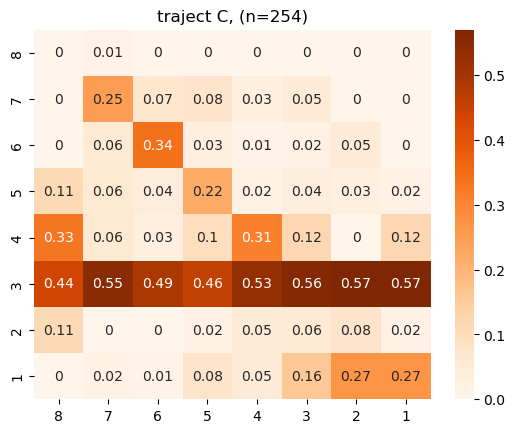

8    0.000000
7    0.284937
6    0.170652
5    0.378660
4    0.674990
3    0.719487
2    0.775265
1    1.000000
Name: days, dtype: float64
8      9.0
7     89.0
6     67.0
5     59.0
4    102.0
3    378.0
2     37.0
1     56.0
dtype: float64


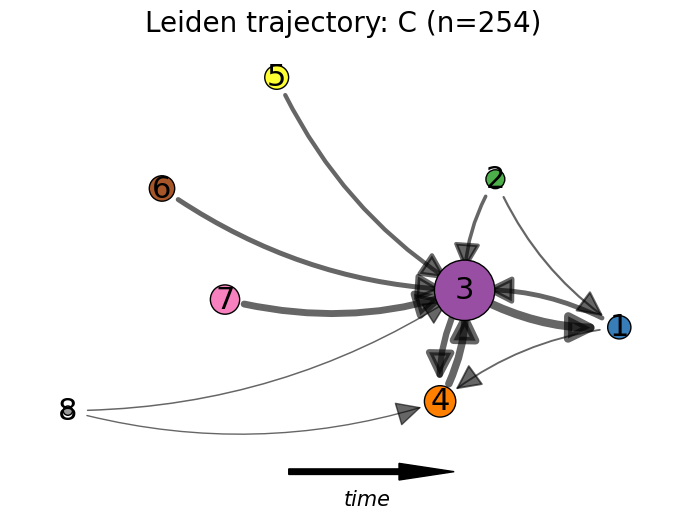

In [101]:
scaling_frame = pd.DataFrame(np.zeros(len(volgorde)), index = volgorde, columns=["days"] )
test_frame = pd.DataFrame(np.zeros((len(volgorde),len(volgorde))), columns=volgorde, index = volgorde )

i = "C"
order = {"left":[8,7,6,5],"middle":[4,3,2],"right":[1]}
general_dataset = Propensity(data_heatmap.query(f"global_trajectory == '{i}'"),                    
                time_column= "days",
                label_column = "label",
                patient_indetifier= "PATNR",
                med_array=dmards,)
general_dataset.calc_transition_matrix()
#traject_counts = general_dataset.count_dict
traject_counts = (general_dataset.count_dict + test_frame).fillna(0).loc[volgorde,volgorde]
print(traject_counts)
patients = len(data_heatmap.query(f"global_trajectory == '{i}'").PATNR.unique())
traject_prob = (traject_counts/traject_counts.sum(axis=0)).round(2).fillna(0)
ax = sns.heatmap(traject_prob.fillna(0), cmap='Oranges', annot=True)
ax.set_title(f"traject {i}, (n={patients})")
plt.show()
traject_test = (traject_prob>=0.12) * traject_counts*7.5
nr_pt_traject = len(data_heatmap.query(f"global_trajectory == '{i}'").PATNR.unique())
#print(traject_data.query("traject_label_y== @i"))
scaling = (data_heatmap.query(f"global_trajectory == '{i}'").groupby("label").days.mean().to_frame() + scaling_frame).fillna(0).loc[volgorde]
scaling = (scaling-scaling.min())/(scaling.max()-scaling.min())
print(scaling.days)
size = (traject_counts.sum(axis=0))
print(size[volgorde])
plot_traject(traject_test, scaling.days, f"Leiden trajectory: {i} (n={nr_pt_traject})", size = size[volgorde]*5, order=order)


/exports/reum/nsteinz/Project_trajectories/trajectories/src/2_clustering/../utils/propensity.py:33: FutureWarning: The 'axis' keyword in SeriesGroupBy.shift is deprecated and will be removed in a future version. Call without passing 'axis' instead.
  .shift(-1, axis=0, fill_value=-1)


      8     7    6     5      4     3     2      1
8   1.0   1.0  0.0   0.0    0.0   0.0   0.0    1.0
7   0.0  19.0  3.0   4.0   10.0   1.0   1.0    6.0
6   0.0   2.0  6.0   0.0    1.0   0.0   1.0    1.0
5   2.0   5.0  0.0  10.0    7.0   2.0   2.0    5.0
4   7.0  29.0  1.0  13.0  107.0  12.0   9.0   92.0
3   1.0   3.0  0.0   1.0   14.0   0.0   3.0   23.0
2   0.0   4.0  0.0   3.0    7.0   1.0   4.0   17.0
1  15.0  38.0  9.0  23.0  195.0  34.0  32.0  380.0


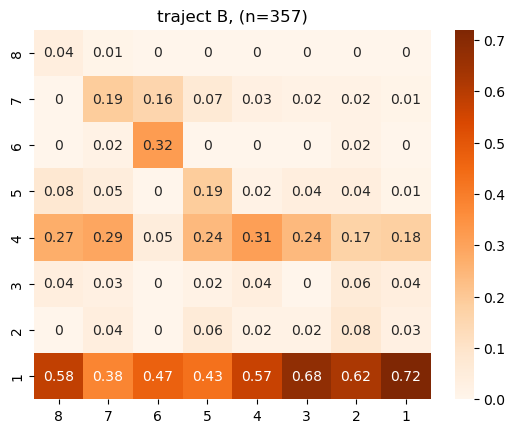

8    0.000000
7    0.143235
6    0.178861
5    0.341991
4    0.510444
3    0.671028
2    0.605212
1    1.000000
Name: days, dtype: float64
8     26.0
7    101.0
6     19.0
5     54.0
4    341.0
3     50.0
2     52.0
1    525.0
dtype: float64


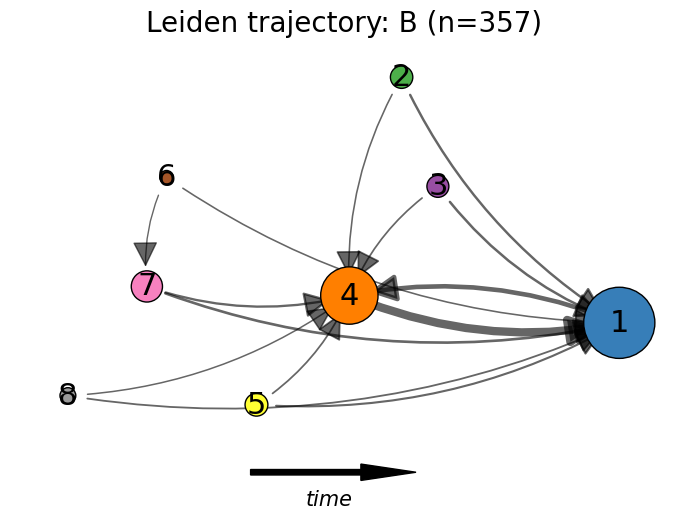

In [102]:
scaling_frame = pd.DataFrame(np.zeros(len(volgorde)), index = volgorde, columns=["days"] )
test_frame = pd.DataFrame(np.zeros((len(volgorde),len(volgorde))), columns=volgorde, index = volgorde )

i = "B"
order = {"left":[8,7,6,],"middle":[5,4,3,2],"right":[1]}
general_dataset = Propensity(data_heatmap.query(f"global_trajectory == '{i}'"),                    
                time_column= "days",
                label_column = "label",
                patient_indetifier= "PATNR",
                med_array=dmards,)
general_dataset.calc_transition_matrix()
#traject_counts = general_dataset.count_dict
traject_counts = (general_dataset.count_dict + test_frame).fillna(0).loc[volgorde,volgorde]
print(traject_counts)
patients = len(data_heatmap.query(f"global_trajectory == '{i}'").PATNR.unique())
traject_prob = (traject_counts/traject_counts.sum(axis=0)).round(2).fillna(0)
ax = sns.heatmap(traject_prob.fillna(0), cmap='Oranges', annot=True)
ax.set_title(f"traject {i}, (n={patients})")
plt.show()
traject_test = (traject_prob>=0.12) * traject_counts*7.5
nr_pt_traject = len(data_heatmap.query(f"global_trajectory == '{i}'").PATNR.unique())
#print(traject_data.query("traject_label_y== @i"))
scaling = (data_heatmap.query(f"global_trajectory == '{i}'").groupby("label").days.mean().to_frame() + scaling_frame).fillna(0).loc[volgorde]
scaling = (scaling-scaling.min())/(scaling.max()-scaling.min())
print(scaling.days)
size = (traject_counts.sum(axis=0))
print(size[volgorde])
plot_traject(traject_test, scaling.days, f"Leiden trajectory: {i} (n={nr_pt_traject})", size = size[volgorde]*5, order=order)


In [105]:
 data_heatmap.query(f"global_trajectory == 'D'").sort_values("days").groupby("PATNR").head(1).Age.describe()

count    197.000000
mean      61.096447
std       13.450432
min       18.000000
25%       53.000000
50%       61.000000
75%       71.000000
max       88.000000
Name: Age, dtype: float64

In [108]:
#data_heatmap.to_csv(data_dir+"/predictie_data.csv", index=False)

In [112]:
for i in data_heatmap.groupby(["PATNR","global_trajectory"]).count().DATUM.reset_index().groupby("global_trajectory"):
    print(f"trajectory: {i[0]}\n", i[1].DATUM.describe().loc[['mean',"std"]])

trajectory: A
 mean    3.895105
std     2.142298
Name: DATUM, dtype: float64
trajectory: B
 mean    4.271709
std     2.049009
Name: DATUM, dtype: float64
trajectory: C
 mean    4.137795
std     2.289499
Name: DATUM, dtype: float64
trajectory: D
 mean    3.908629
std     2.367246
Name: DATUM, dtype: float64


In [113]:
data_heatmap.sort_values("DATUM").groupby("PATNR").tail(1).das28.describe()

count    1237.000000
mean        3.005904
std         1.288879
min         0.684019
25%         2.063108
50%         2.853560
75%         3.861198
max         7.096554
Name: das28, dtype: float64

In [114]:
x = data_heatmap.sort_values("DATUM").groupby("PATNR").head(1)[["PATNR", "global_trajectory","das44"]].rename(columns={"das44":"das44_bl"}).merge(
data_heatmap.sort_values("DATUM").groupby("PATNR").tail(1)[["PATNR","global_trajectory","das44"]].rename(columns={"das44":"das44_lv"}))

x["delta_das44"] = x.das44_lv - x.das44_bl
x.groupby("global_trajectory").delta_das44.describe()
print(
          f"{round(x.delta_das44.median(),2)}",
          f" ({round(x.delta_das44.quantile(q=0.25),2)} - {round(x.delta_das44.quantile(q=0.75),2)})")
for i in x.groupby("global_trajectory"):
    print(f"trajectory: {i[0]}\n",
          f"{round(i[1].delta_das44.median(),2)}",
          f" ({round(i[1].delta_das44.quantile(q=0.25),2)} - {round(i[1].delta_das44.quantile(q=0.75),2)})")

-0.86  (-1.63 - -0.09)
trajectory: A
 -0.71  (-1.45 - 0.03)
trajectory: B
 -0.93  (-1.67 - -0.3)
trajectory: C
 -0.78  (-1.49 - -0.06)
trajectory: D
 -1.22  (-2.02 - -0.13)


In [116]:
data_heatmap.groupby("PATNR").remision.max().mean()

0.5691188358932903

In [117]:
for i in data_heatmap.sort_values("DATUM").groupby("PATNR").tail(1).groupby("global_trajectory"):
    print(f"trajectory: {i[0]}\n",i[1].das28.describe())

trajectory: A
 count    429.000000
mean       3.716679
std        1.146840
min        0.684019
25%        2.828125
50%        3.720405
75%        4.466250
max        7.096554
Name: das28, dtype: float64
trajectory: B
 count    357.000000
mean       2.125339
std        0.953830
min        0.684019
25%        1.514570
50%        2.033964
75%        2.676418
max        5.931371
Name: das28, dtype: float64
trajectory: C
 count    254.000000
mean       2.758263
std        1.150497
min        0.684019
25%        1.972809
50%        2.598890
75%        3.405221
max        6.719297
Name: das28, dtype: float64
trajectory: D
 count    197.000000
mean       3.373115
std        1.228644
min        0.684019
25%        2.498419
50%        3.318335
75%        4.174266
max        6.815729
Name: das28, dtype: float64


In [118]:
for i in data_heatmap.sort_values("DATUM").groupby("PATNR").tail(1).groupby("global_trajectory"):
    print(f"trajectory: {i[0]}\n",i[1].TJC_28_o.describe())

trajectory: A
 count    429.000000
mean       2.652681
std        3.543208
min        0.000000
25%        0.000000
50%        2.000000
75%        4.000000
max       26.000000
Name: TJC_28_o, dtype: float64
trajectory: B
 count    357.000000
mean       1.434174
std        2.578924
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max       26.000000
Name: TJC_28_o, dtype: float64
trajectory: C
 count    254.000000
mean       1.996063
std        3.380364
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max       24.000000
Name: TJC_28_o, dtype: float64
trajectory: D
 count    197.000000
mean       4.847716
std        4.848433
min        0.000000
25%        1.000000
50%        4.000000
75%        7.000000
max       26.000000
Name: TJC_28_o, dtype: float64


In [119]:
for i in data_heatmap.sort_values("DATUM").groupby("PATNR").tail(1).groupby("global_trajectory"):
    print(f"trajectory: {i[0]}\n",i[1].SJC_28_o.describe())

trajectory: A
 count    429.000000
mean       2.083916
std        3.012039
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max       19.000000
Name: SJC_28_o, dtype: float64
trajectory: B
 count    357.000000
mean       0.596639
std        1.315333
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       10.000000
Name: SJC_28_o, dtype: float64
trajectory: C
 count    254.000000
mean       1.377953
std        2.390459
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max       15.000000
Name: SJC_28_o, dtype: float64
trajectory: D
 count    197.000000
mean       3.467005
std        3.708124
min        0.000000
25%        0.000000
50%        3.000000
75%        5.000000
max       22.000000
Name: SJC_28_o, dtype: float64


In [120]:
for i in data_heatmap.sort_values("DATUM").groupby("PATNR").tail(1).groupby("global_trajectory"):
    print(f"trajectory: {i[0]}\n",i[1].ESR_o.describe())

trajectory: A
 count    429.000000
mean      36.180653
std       25.212473
min        2.000000
25%       19.000000
50%       32.000000
75%       45.000000
max      131.000000
Name: ESR_o, dtype: float64
trajectory: B
 count    357.000000
mean       8.326331
std        7.324967
min        2.000000
25%        2.000000
50%        6.000000
75%       11.000000
max       75.000000
Name: ESR_o, dtype: float64
trajectory: C
 count    254.000000
mean      14.773622
std       13.220124
min        2.000000
25%        6.000000
50%       11.000000
75%       19.000000
max      115.000000
Name: ESR_o, dtype: float64
trajectory: D
 count    197.000000
mean      13.182741
std       13.433685
min        2.000000
25%        6.000000
50%        9.000000
75%       17.000000
max       94.000000
Name: ESR_o, dtype: float64


In [122]:
query = "TJC_28_o"
print(data_heatmap.sort_values("DATUM").groupby("PATNR").head(1)[query].describe())
for i in data_heatmap.sort_values("DATUM").groupby("PATNR").head(1).groupby("global_trajectory"):
    print(f"trajectory: {i[0]}\n",i[1][query].describe())

count    1237.000000
mean        5.592563
std         5.242706
min         0.000000
25%         2.000000
50%         4.000000
75%         8.000000
max        27.000000
Name: TJC_28_o, dtype: float64
trajectory: A
 count    429.000000
mean       5.034965
std        4.636929
min        0.000000
25%        2.000000
50%        4.000000
75%        7.000000
max       25.000000
Name: TJC_28_o, dtype: float64
trajectory: B
 count    357.000000
mean       4.560224
std        4.384586
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       24.000000
Name: TJC_28_o, dtype: float64
trajectory: C
 count    254.000000
mean       4.582677
std        4.618986
min        0.000000
25%        1.000000
50%        3.000000
75%        7.000000
max       27.000000
Name: TJC_28_o, dtype: float64
trajectory: D
 count    197.000000
mean       9.979695
std        6.374342
min        0.000000
25%        5.000000
50%        9.000000
75%       15.000000
max       24.000000
Name: TJ

In [123]:
query = "SJC_28_o"
print(data_heatmap.sort_values("DATUM").groupby("PATNR").head(1)[query].describe())
for i in data_heatmap.sort_values("DATUM").groupby("PATNR").head(1).groupby("global_trajectory"):
    print(f"trajectory: {i[0]}\n",i[1][query].describe())

count    1237.000000
mean        4.518189
std         4.757284
min         0.000000
25%         1.000000
50%         3.000000
75%         7.000000
max        24.000000
Name: SJC_28_o, dtype: float64
trajectory: A
 count    429.000000
mean       4.006993
std        4.095524
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       24.000000
Name: SJC_28_o, dtype: float64
trajectory: B
 count    357.000000
mean       3.498599
std        3.891524
min        0.000000
25%        0.000000
50%        2.000000
75%        5.000000
max       18.000000
Name: SJC_28_o, dtype: float64
trajectory: C
 count    254.000000
mean       3.767717
std        4.190756
min        0.000000
25%        1.000000
50%        2.000000
75%        6.000000
max       22.000000
Name: SJC_28_o, dtype: float64
trajectory: D
 count    197.000000
mean       8.446701
std        6.099804
min        0.000000
25%        4.000000
50%        7.000000
75%       13.000000
max       24.000000
Name: SJ

In [124]:
query = "ESR_o"
print(data_heatmap.sort_values("DATUM").groupby("PATNR").head(1)[query].describe())
for i in data_heatmap.sort_values("DATUM").groupby("PATNR").head(1).groupby("global_trajectory"):
    print(f"trajectory: {i[0]}\n",i[1][query].describe())

count    1237.000000
mean       32.980598
std        28.206733
min         2.000000
25%        11.000000
50%        28.000000
75%        45.000000
max       138.000000
Name: ESR_o, dtype: float64
trajectory: A
 count    429.000000
mean      51.475524
std       29.459877
min        2.000000
25%       31.000000
50%       43.000000
75%       67.000000
max      138.000000
Name: ESR_o, dtype: float64
trajectory: B
 count    357.000000
mean      17.683473
std       15.943698
min        2.000000
25%        6.000000
50%       14.000000
75%       25.000000
max      115.000000
Name: ESR_o, dtype: float64
trajectory: C
 count    254.000000
mean      28.102362
std       25.388004
min        2.000000
25%       11.000000
50%       19.000000
75%       36.000000
max      138.000000
Name: ESR_o, dtype: float64
trajectory: D
 count    197.000000
mean      26.715736
std       24.149258
min        2.000000
25%        9.000000
50%       19.000000
75%       36.000000
max      128.000000
Name: ESR_o, dtype: 

In [125]:
for i in data_heatmap.sort_values("DATUM").groupby("global_trajectory"):
    print(f"trajectory: {i[0]}\n",i[1].groupby("PATNR").remision.max().mean())

trajectory: A
 0.2540792540792541
trajectory: B
 0.9047619047619048
trajectory: C
 0.7244094488188977
trajectory: D
 0.4467005076142132


In [126]:
x = data_heatmap.sort_values("DATUM").query("days_nlp >=0").groupby("PATNR").head(1)
#data_heatmap.groupby("PATNR").head(1)[["PATNR", "traject_label"]]
for i in x.groupby("global_trajectory"):
    print(f"global_trajectory: {i[0]}",
          f"\nmedian: {i[1].days.median()}",
          f" ({i[1].days.quantile(q=0.25)} - {i[1].days.quantile(q=0.75)})")
    print(
          f"mean: {i[1].days.mean()}",
          f" (std: {i[1].days.std()})")


global_trajectory: A 
median: 0.0  (0.0 - 105.5)
mean: 64.30272952853598  (std: 116.81785229331032)
global_trajectory: B 
median: 0.0  (0.0 - 118.75)
mean: 59.51156069364162  (std: 105.11385757533932)
global_trajectory: C 
median: 0.0  (0.0 - 81.0)
mean: 58.378151260504204  (std: 109.18064553885384)
global_trajectory: D 
median: 0.0  (0.0 - 100.5)
mean: 61.734042553191486  (std: 100.93187998053244)


trajectory: A
 0.0  (0.0 - 0.0)
trajectory: B
 0.0  (0.0 - 0.0)
trajectory: C
 0.0  (0.0 - 0.0)
trajectory: D
 0.0  (0.0 - 0.0)


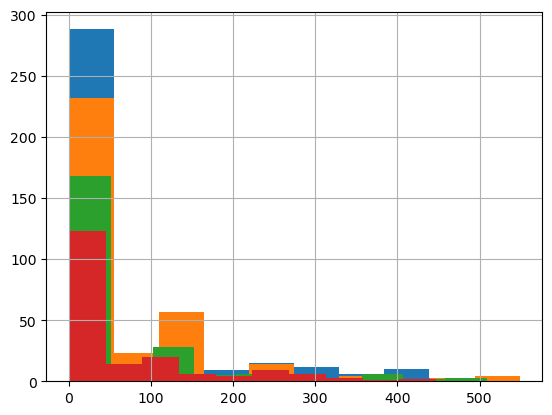

In [127]:
x = data_heatmap.sort_values("DATUM").query("days_nlp >=0").groupby("PATNR").head(1)
#data_heatmap.groupby("PATNR").head(1)[["PATNR", "traject_label"]]
for i in x.groupby("global_trajectory"):
    print(f"trajectory: {i[0]}\n",
          f"{i[1].days_nlp.median()}",
          f" ({i[1].days_nlp.quantile(q=0.25)} - {i[1].days_nlp.quantile(q=0.75)})")
    i[1].days.hist()


In [128]:
for i in data_heatmap.groupby(["PATNR"]).head(1).groupby("global_trajectory"):
    print(f"trajectory: {i[0]}\n",i[1][["aCCP positive",'RF positive', 'Age', 'sex']].mean())

trajectory: A
 aCCP positive     0.529138
RF positive       0.505828
Age              63.009324
sex               0.720280
dtype: float64
trajectory: B
 aCCP positive     0.448179
RF positive       0.453782
Age              56.025210
sex               0.599440
dtype: float64
trajectory: C
 aCCP positive     0.511811
RF positive       0.484252
Age              58.763780
sex               0.610236
dtype: float64
trajectory: D
 aCCP positive     0.274112
RF positive       0.345178
Age              61.096447
sex               0.604061
dtype: float64


In [129]:
for i in data_heatmap.sort_values("DATUM").groupby("PATNR").head(1)[["label","global_trajectory"]].groupby("global_trajectory"):
    print(f"trajectory: {i[0]}\n",i[1][["label"]].value_counts()/i[1][["label"]].count().values)

trajectory: A
 label
6        0.321678
5        0.249417
2        0.228438
7        0.093240
4        0.037296
8        0.025641
3        0.023310
1        0.020979
Name: count, dtype: float64
trajectory: B
 label
4        0.333333
1        0.249300
7        0.165266
8        0.064426
2        0.061625
5        0.061625
3        0.039216
6        0.025210
Name: count, dtype: float64
trajectory: C
 label
3        0.362205
7        0.177165
6        0.125984
4        0.110236
5        0.094488
2        0.055118
1        0.043307
8        0.031496
Name: count, dtype: float64
trajectory: D
 label
7        0.604061
4        0.253807
6        0.045685
8        0.045685
5        0.030457
1        0.010152
2        0.010152
Name: count, dtype: float64


In [132]:
for i in data_heatmap.groupby("PATNR").head(1)[["label","global_trajectory"]].groupby("global_trajectory"):
    print(f"trajectory: {i[0]}\n",i[1][["label"]].median())

trajectory: A
 label    5.0
dtype: float64
trajectory: B
 label    4.0
dtype: float64
trajectory: C
 label    4.0
dtype: float64
trajectory: D
 label    7.0
dtype: float64


In [133]:
data_heatmap.columns

Index(['TJC_28', 'SJC_28', 'ESR', 'leukocytes', 'hb_corrected', 'MCV',
       'thrombocytes', 'TJC_28_o', 'SJC_28_o', 'ESR_o', 'leukocytes_o',
       'hb_corrected_o', 'MCV_o', 'thrombocytes_o', 'das28_n', 'das28',
       'das44', 'SJC_44_o', 'TJC_44_o', 'aCCP positive', 'RF positive',
       'label', 'days', 'days_nlp', 'PATNR', 'DATUM', 'Age', 'sex',
       'dmard_usage', 'symptomDuration', 'Hemoglobine', 'sequence', 'Age_n',
       'remision', 'ABATACEPT', 'ADALIMUMAB', 'ANAKINRA',
       'SODIUM_AUROTHIOMALATE', 'AZATHIOPRINE', 'BARICITINIB',
       'CERTOLIZUMAB_PEGOL', 'CICLOSPORINE', 'CYCLOPHOSPHAMIDE', 'ETANERCEPT',
       'GOLIMUMAB', 'HYDROXYCHLOROQUINE', 'INFLIXIMAB', 'LEFLUNOMIDE',
       'METHOTREXATE', 'SULFASALAZINE', 'TOCILIZUMAB', 'TOFACITINIB',
       'METHYLPREDNISOLONE', 'PREDNISOLONE', 'TNF_b_dmards', 'IL6_b_dmards',
       'IL1_b_dmards', 'tcell_b_dmards', 'cs_dmards', 'jak_dmard', 'XO_damrd',
       'OP_dmard', 'TC_dmard', 'gld_dmard', 'count', 'no_med', 'med',
 

In [134]:
for i in data_heatmap.groupby("PATNR").max().groupby("global_trajectory"):
    print(f"trajectory: {i[0]}\n",i[1]["remision"].mean())

trajectory: A
 0.2540792540792541
trajectory: B
 0.9047619047619048
trajectory: C
 0.7244094488188977
trajectory: D
 0.4467005076142132


In [136]:
for i in data_heatmap.groupby("PATNR").max().groupby("global_trajectory"):
    print(f"trajectory: {i[0]}\n",i[1]["dmard_usage"].mean())

trajectory: A
 0.9393939393939394
trajectory: B
 0.9635854341736695
trajectory: C
 0.9645669291338582
trajectory: D
 0.9593908629441624


In [137]:
for i in data_heatmap.groupby("PATNR").tail(1).groupby("global_trajectory"):
    print(f"trajectory: {i[0]}\n",i[1]["days"].describe().loc[['mean',"std"]])

trajectory: A
 mean    304.673660
std     163.811111
Name: days, dtype: float64
trajectory: B
 mean    349.515406
std     139.796754
Name: days, dtype: float64
trajectory: C
 mean    308.700787
std     158.300900
Name: days, dtype: float64
trajectory: D
 mean    280.746193
std     162.723744
Name: days, dtype: float64


In [138]:
data = data_heatmap.groupby("PATNR").head(1)[["global_trajectory", "symptomDuration"]]
data = data.query("symptomDuration > 0").symptomDuration
print(f"trajectory: {i[0]}  (n= {len(data)})\n",
          f"{data.median()}",
          f" ({data.quantile(q=0.25)} - {data.quantile(q=0.75)})"
             )

trajectory: D  (n= 381)
 155.0  (62.0 - 547.5)


In [139]:
print("symptomDuration (days)")
for i in data_heatmap.groupby("PATNR").head(1)[["global_trajectory", "symptomDuration"]].groupby("global_trajectory"):
    data = i[1].query("symptomDuration > 0").symptomDuration
    print(f"trajectory: {i[0]}  (n= {len(data)})\n",
          f"{data.median()}",
          f" ({data.quantile(q=0.25)} - {data.quantile(q=0.75)})"
             )

symptomDuration (days)
trajectory: A  (n= 122)
 154.0  (62.0 - 730.0)
trajectory: B  (n= 111)
 180.0  (62.0 - 545.75)
trajectory: C  (n= 86)
 232.5  (79.875 - 730.0)
trajectory: D  (n= 62)
 114.75  (42.0 - 276.25)


In [141]:
data_heatmap.symptomDuration.describe()

count    5017.000000
mean      224.396153
std       918.204758
min     -1991.000000
25%         0.000000
50%         0.000000
75%        62.000000
max      9126.000000
Name: symptomDuration, dtype: float64

In [142]:
print("start METHOTREXATE usage (days)")
for i in data_heatmap.sort_values("days").query("METHOTREXATE == 1").groupby("PATNR",sort="days").head(1)[["global_trajectory", "days"]].groupby("global_trajectory"):
    data = i[1].query("days>0").days
    #print(f"trajectory: {i[0]}",)
    #print(data.hist(label= f"{i[0]}"))
    #print()
    print(f"trajectory: {i[0]}\n",
          f"{data.median()}",
          f" ({data.quantile(q=0.25)} - {data.quantile(q=0.75)})"
             )
#    print(f"trajectory: {i[0]}\n",
#          f"{data.mean().values[0]}",
#          f" ({data.std()[0]})"
#             )

start METHOTREXATE usage (days)
trajectory: A
 123.5  (42.0 - 217.0)
trajectory: B
 126.0  (51.0 - 233.75)
trajectory: C
 139.0  (70.0 - 254.0)
trajectory: D
 112.5  (43.75 - 154.25)


In [143]:
data_heatmap.query("METHOTREXATE == 1").groupby("PATNR").head(1)

,TJC_28,SJC_28,ESR,leukocytes,hb_corrected,MCV,thrombocytes,TJC_28_o,SJC_28_o,ESR_o,...,sero_negative,seropos,from_clust,global_trajectory_o,communi_x,L2,L1,communi_y,global_trajectory,communi
1,0.071429,0.125000,0.051471,0.403387,0.608209,0.912281,0.307782,2.0,3.0,9.0,...,False,True,6,3,2,0,0,2,C,2
3,0.000000,0.000000,0.125000,0.081633,0.289179,0.789474,0.313589,0.0,0.0,19.0,...,False,True,-1,3,2,0,0,2,C,2
7,0.428571,0.416667,0.110294,0.454624,0.843284,0.754386,0.270616,12.0,10.0,17.0,...,False,True,-1,2,3,0,0,3,B,3
12,0.107143,0.000000,0.301471,0.343031,0.664179,0.780702,0.432056,3.0,0.0,43.0,...,False,True,-1,1,1,1,0,1,A,1
15,0.035714,0.041667,0.198529,0.056231,0.244403,0.780702,0.335656,1.0,1.0,29.0,...,False,True,-1,2,0,0,0,0,B,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5004,0.000000,0.041667,0.000000,0.219279,0.865672,0.745614,0.271777,0.0,1.0,2.0,...,True,False,1,2,0,0,1,0,B,0
5006,0.000000,0.250000,0.191176,0.235779,0.552239,0.780702,0.332172,0.0,6.0,28.0,...,True,False,-1,2,0,0,0,0,B,0
5010,0.000000,0.000000,0.029412,0.124620,0.686567,0.912281,0.146341,0.0,0.0,6.0,...,True,False,-1,2,0,0,1,0,B,0
5013,0.000000,0.000000,0.000000,0.281372,0.630597,0.701754,0.349593,0.0,0.0,2.0,...,False,True,1,3,2,0,0,2,C,2


In [144]:
print("start PREDNISOLONE usage (days)")
for i in data_heatmap.sort_values("days").query("PREDNISOLONE == 1").groupby("PATNR").head(1)[["global_trajectory", "days"]].groupby("global_trajectory"):
    data = i[1].days
    #print(data)
    print(f"trajectory: {i[0]}\n",
          f"{data.median()}",
          f" ({data.quantile(q=0.25)} - {data.quantile(q=0.75)})"
             )

start PREDNISOLONE usage (days)
trajectory: A
 0.0  (0.0 - 123.0)
trajectory: B
 0.0  (0.0 - 124.0)
trajectory: C
 0.0  (0.0 - 123.0)
trajectory: D
 0.0  (0.0 - 77.5)


In [145]:
print("start dmard_usage (days)")
for i in data_heatmap.query("dmard_usage == 1").groupby("PATNR").head(1)[["global_trajectory", "days"]].groupby("global_trajectory"):
    data = i[1]
    print(f"trajectory: {i[0]}\n",
          f"{data.days.median()}",
          f" ({data.days.quantile(q=0.25)} - {data.days.quantile(q=0.75)})"
             )
data.days

start dmard_usage (days)
trajectory: A
 0.0  (0.0 - 0.0)
trajectory: B
 0.0  (0.0 - 0.0)
trajectory: C
 0.0  (0.0 - 11.0)
trajectory: D
 0.0  (0.0 - 0.0)


83        0
89        0
95        0
123     125
226       0
       ... 
4902    280
4905     22
4915      0
4917      0
4948      0
Name: days, Length: 189, dtype: int64

In [148]:
(data_heatmap.sort_values("DATUM").groupby("PATNR").shift(-1)[dmards] - data_heatmap.sort_values("DATUM")[dmards]).sum(axis=1).sum()/len(data_heatmap.sort_values("DATUM").groupby("PATNR").shift(-1).dropna())

0.038624338624338624